# Определение уязвимых групп населения
## Итоговый проект первого года обучения Skillfactory Профессия Data Science

In [1]:
#импортируем библиотеки и модули
import pandas as pd
import numpy as np
import pickle
import regex as re
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import xlrd
import openpyxl

from datetime import datetime, date, time
from plotly.subplots import make_subplots
from scipy.stats import shapiro, kruskal, mannwhitneyu
from sklearn import cluster, metrics
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.proportion import proportions_chisquare
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## 1. Формирование DataFrame
Собираем данные из предоставленных в проекте файлов, и частично из дополнительных источников.

Сведения предоставлены по 85 федеральным субъектам. 

Архангельская, Тюменская области и автономные округа в их составе рассматриваются по-отдельности.

In [2]:
# Функция для извлечения данных по федеральным субъектам.
def federal_subj(
    # standard_names - словарь стандартных названий,
    # region_col - столбец с названиями регионов, 
    # names_to_drop - словарь  для исключения регионов, которые могут быть ошибочно обработаны функцией как федеральные субъекты.
    df, standard_names, names_to_drop=None, region_col='region'): 
    "Считывание данных по федеральным субъектам"
    
    def get_standard_name(x):
        "Функция для .apply() Просмотр столбца регионов и вывод названий в стандартном виде"
    
        for key, value in standard_names.items():
            x = re.sub('[\(].*?[\)]', '', x)  # удаляем информацию в скобках
            if re.search(key, x.lower()):
                return value
        return None
    
    if names_to_drop is None:
        names_to_drop = []
    df = df[~df[region_col].isin(names_to_drop)].copy()
    df[region_col] = df[region_col].apply(get_standard_name)
    return (df.dropna(subset=region_col)
            .set_index(region_col).sort_index()) 

## 1.1. Денежные доходы

### Описание Dataframe
per_capita   -   Среднедушевые денежные доходы (в месяц), руб.

real_incomes-   Реальные денежные доходы, в процентах к предыдущему году (покупательная способность: с учетом роста цен)

formal_wage -   Среднемесячная номинальная начисленная заработная плата, руб.

real_pay    -   Реальная начисленная заработная плата, в процентах к предыдущему году (покупательная способность: с учетом роста цен)

In [3]:
def finances_readout(file, sheet):
    "Считывание финансовых данных с excel-листа"
    df = pd.read_excel(file, sheet_name=sheet)
    # names_to_drop - словарь  для исключения регионов, которые могут быть ошибочно обработаны функцией как федеральные субъекты
    names_to_drop = ['Архангельская область', 'Тюменская область'] 
    df = federal_subj(df, standard_names, names_to_drop)
    df.columns = pd.to_datetime((df.columns).astype(int), format='%Y').year
    return df
    

with open('data/social_russia_data/standard_names.pkl', 'rb') as f:
    standard_names = pickle.load(f)
file = 'data/social_russia_data/cash_real_income_wages_2015_2020.xlsx'
per_capita = finances_readout(file, 0)
real_incomes = finances_readout(file, 1)
formal_wage = finances_readout(file, 2)
real_pay = finances_readout(file, 3)

display('Номинальный доход', per_capita.head(3))
display('Реальный доход, %', real_incomes.head(3))
display('Номинальная зарплата', formal_wage.head(3))
display('Реальная зарпалата, %', real_pay.head(3))

'Номинальный доход'

,2015,2016,2017,2018,2019,2020
region,,,,,,
Алтайский край,20860.0,21256.0,22139.0,22829.0,23937.0,23864.0
Амурская область,28240.0,27976.0,29213.0,30937.0,33304.0,35499.0
Архангельская область без Ненецкого АО,29716.0,29837.0,30707.0,32054.0,33874.0,34852.0


'Реальный доход, %'

,2015,2016,2017,2018,2019,2020
region,,,,,,
Алтайский край,99.1,94.7,100.0,99.7,99.6,95.5
Амурская область,96.1,92.1,101.1,102.4,101.7,100.3
Архангельская область без Ненецкого АО,95.1,93.0,98.7,101.7,100.2,98.4


'Номинальная зарплата'

,2015,2016,2017,2018,2019,2020
region,,,,,,
Алтайский край,20090.0,21202.0,22743.0,25519.0,27962.0,30072.0
Амурская область,32902.0,33837.0,37368.0,42315.0,47234.0,52430.0
Архангельская область без Ненецкого АО,35592.0,38118.0,40352.0,45427.0,49435.0,52779.0


'Реальная зарпалата, %'

,2015,2016,2017,2018,2019,2020
region,,,,,,
Алтайский край,90,98.4,103.6,109.3,104.9,103.8
Амурская область,88,96.0,107.4,110.1,106.0,105.2
Архангельская область без Ненецкого АО,92.4,100.0,102.5,110.7,104.0,102.9


## 1.2. Детская смертность
Единица измерения - количество человек. 

Объединим данные по популяции городской и сельской местности.
Данные по Архангельской и Тюменской областям пересчитываем отдельно из-за разницы в организации данных в зависимости от года. 

In [4]:
def mortality_readout(file):

    df = pd.read_excel(file, header=2, skipfooter=13, usecols='A, D:AI') # Считывание данных с excel-файла
    df.rename({'Unnamed: 0': 'region'}, axis=1, inplace=True)
    # names_to_drop - словарь  для исключения регионов, которые могут быть ошибочно обработаны функцией как федеральные субъекты
    names_to_drop = [
        '            Архангельская область (кроме Ненецкого автономного округа)',
        '            Тюменская область (кроме Ханты-Мансийского автономного округа-Югры и Ямало-Ненецкого автономного округа)', 
    ]
    df = federal_subj(df, standard_names, names_to_drop)
    df.loc['Архангельская область без Ненецкого АО'] \
        = (df.loc['Архангельская область без Ненецкого АО']
        - df.loc['Ненецкий автономный округ'])
    df.loc['Тюменская область без округов'] \
        = (df.loc['Тюменская область без округов']
        - df.loc['Ханты-Мансийский автономный округ - Югра']
        - df.loc['Ямало-Ненецкий автономный округ'])
    df.columns = pd.to_datetime(df.columns, format='%Y').year
    return df


rural = mortality_readout(
    'data/social_russia_data/child_mortality_rural_1990_2021.xls') # DataFrame по смертности среди детей сельской местности
urban = mortality_readout(
    'data/social_russia_data/child_mortality_urban_1990_2021.xls') # DataFrame по смертности среди детей городской местности
child_mortality = rural.add(urban) #обобщенный DataFrame по смертности среди детей сельской и городской местности
child_mortality.head(3)

,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
region,,,,,,,,,,,,,,,,,,,,,
Алтайский край,522.0,567.0,529.0,560.0,497.0,490.0,405.0,375.0,340.0,391.0,...,330.0,290.0,275.0,222.0,211.0,185.0,176.0,114.0,97.0,88.0
Амурская область,343.0,293.0,280.0,244.0,242.0,250.0,245.0,268.0,246.0,270.0,...,161.0,119.0,101.0,83.0,53.0,48.0,46.0,43.0,42.0,36.0
Архангельская область без Ненецкого АО,288.0,274.0,245.0,237.0,224.0,206.0,194.0,157.0,167.0,168.0,...,108.0,113.0,97.0,84.0,79.0,72.0,53.0,58.0,29.0,32.0


## 1.3. Инвалидность среди трудоспособного возраста
Единица измерения - количество человек. 

Таблица содержит данные по месяцам и для разных возрастов.

За точку отсчёта берем данные на 1 января каждого года.

Количество инвалидов пожилого возраста зависит и от естественного старения. 
Инвалидность среди трудоспособного населения дает более точную оценку социального неблагополучия региона.  

In [5]:
disabled = pd.read_csv(
    'data/social_russia_data/disabled_total_by_age_2017_2022.csv')
disabled = federal_subj(disabled, standard_names)

disabled['date'] = pd.to_datetime(disabled['date'])
disabled['dayofyear'] = disabled['date'].dt.dayofyear
disabled = disabled[disabled['dayofyear'] == 1]
disabled['young'] = disabled[['18_30', '31_40', '41_50', '51_60']].sum(axis=1)
disabled_18_60 = pd.pivot_table(
    data=disabled, values='young', index='region', columns='date')
disabled_18_60.columns = (disabled_18_60.columns).year
disabled_18_60.head(5)

date,2017,2018,2019,2020,2021,2022
region,,,,,,
Алтайский край,66770.0,64605.0,62840.0,61378.0,59810.0,59006.0
Амурская область,27892.0,26720.0,25976.0,25069.0,24149.0,23356.0
Архангельская область без Ненецкого АО,29228.0,28262.0,27615.0,26984.0,26498.0,26009.0
Астраханская область,21018.0,20394.0,19822.0,19534.0,19391.0,19313.0
Белгородская область,70741.0,66742.0,63964.0,60716.0,58208.0,55509.0


## 1.4. Алкоголизм, наркомания
Единица измерения - количество акогольных/наркотических психозов на 100 тыс. населения.

In [6]:
def alco_readout(file, sheet):

    df = pd.read_excel(file, sheet_name=sheet)
    df = federal_subj(df, standard_names)
    df.columns = pd.to_datetime((df.columns).astype(int), format='%Y').year
    return df


file = 'data/social_russia_data/drug_alco.xlsx'
alco = alco_readout(file, 0)
alco1718 = alco_readout(file, 1)
drug = alco_readout(file, 2)
drug1718 = alco_readout(file, 3)
alco = pd.concat([alco, alco1718], axis=1).sort_index()
drug = pd.concat([drug, drug1718], axis=1).sort_index()

alco = alco.astype (float)
drug = drug.astype (float)

display('Алкоголизм', alco.head(3))
display('Наркомания', drug.head(3))

'Алкоголизм'

,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
region,,,,,,,,,,,,,,
Алтайский край,227.6,202.4,173.9,199.8,177.9,164.0,157.6,138.9,105.0,111.9,115.7,100.1,85.9,88.1
Амурская область,174.3,159.0,120.9,113.3,115.5,140.5,124.7,104.8,100.0,96.7,97.2,92.3,91.4,113.3
Архангельская область без Ненецкого АО,120.1,115.2,102.5,89.8,96.5,99.5,84.4,73.2,77.6,NaN,NaN,NaN,55.3,64.7


'Наркомания'

,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
region,,,,,,,,,,,,,,
Алтайский край,29.8,35.2,35.2,37.7,27.3,24.5,26.4,33.4,22.9,21.6,20.7,17.4,17.4,17.4
Амурская область,21.3,27.2,27.2,28.4,26.2,37.1,33.9,24.2,22.5,22.2,19.1,18.9,18.7,24.4
Архангельская область без Ненецкого АО,1.5,1.4,1.4,2.6,3.4,4.6,6.4,4.0,4.0,NaN,NaN,NaN,5.4,9.2


## 1.5. Валовой региональный продукт на душу населения 
Данные пердоставлены в рублях, значение показателя за год.

Считываем данные с 2011 года - обеспечивается единая методика расчета по Архангельской и Тюменской областям.

In [7]:
grp = pd.read_excel('data/social_russia_data/gross_regional_product_1996_2020.xls', 
                    header=2, skipfooter=1, usecols='A, Q:Z')
grp.rename({'Unnamed: 0': 'region'}, axis=1, inplace=True)
names_to_drop = [
    '        Архангельская область',
    '        Тюменская область']
grp = federal_subj(grp, standard_names, names_to_drop)
grp.columns = pd.to_datetime(grp.columns).year
grp.head(3)

,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
region,,,,,,,,,,
Алтайский край,137677.2,153556.7,173763.5,186798.6,204933.1,224525.8,231268.4,247599.3,271319.7,291156.9
Амурская область,273175.8,280023.9,258817.0,286282.6,343385.7,370192.4,373935.1,419905.2,521060.1,571362.1
Архангельская область без Ненецкого АО,232540.7,270662.9,283264.5,310817.4,352837.9,400764.6,441961.6,493205.1,509917.0,514200.4


## 1.6. Жилищные условия по данным 2020 г.
Соберем данные в DataFrame:
- среднюю жилую площадь на одного человека;
- процент домохозяйств, указавших на плохое состояние жилого помещения;
- процент встающих в очередь на жилье или рассчитывающих на переселение в связи со сносом дома (процент домохозяйств, не имеющих средств для улучшения жилищных условий).

In [8]:
def housing_readout(file, sheet, cols, skipfooter=0):
    "Считывание данных с excel-файла"
    df = pd.read_excel(
        file, sheet_name=sheet, usecols=cols, skipfooter=skipfooter)
    df.rename({'Регион': 'region'}, axis=1, inplace=True)
    
    # Произведем замену ошибочного написания названий
    df.replace({'Bладимирская область': 'Владимирская'}, inplace=True)
    df.replace({'Bолгоградская область': 'Волгоградская'}, inplace=True)
    df.replace({'Bологодская область': 'Вологодская'}, inplace=True)
    df.replace({'Bоронежская область': 'Воронежская'}, inplace=True)
    df.replace('...', 0, inplace=True)  # слабая статистика -> 0
    df = federal_subj(df, standard_names)
    return df


file = 'data/social_russia_data/housing_2020.xlsx'
living_area = housing_readout(file, 0, 'A, H')
living_area.columns.values[0] = 'living area'
intents = housing_readout(file, 1, 'A, C, E, H, I', 2)
intents.columns.values[0] = 'to improve'
intents.columns.values[1] = 'bad conditions'
intents.columns.values[2] = 'queue'
intents.columns.values[3] = 'demolition'
intents['no funds'] = ((intents['to improve']/100 
    * (intents['queue']/100 + intents['demolition']/100)) * 100)
housing = pd.concat(
    [living_area, intents[['bad conditions', 'no funds']]], axis=1)
housing.head(3)

,living area,bad conditions,no funds
region,,,
Алтайский край,18.0,0.3,0.8642
Амурская область,17.3,1.3,1.0731
Архангельская область без Ненецкого АО,16.9,1.4,1.2998


## 1.7. Заболеваемость (на 100 тыс.человек населения, на 1 января)

Для обеспечения единой методики расчета по Архангельской и Тюменской областям берем данные с 2014 г. (при этом статистика по областям без автономных округов до 2014 г. не приводится).

Данные позже 2016 г. отсутствуют.

Создадим DataFrame c диагнозамb, которые связаны с социальным неблагополучием.

In [9]:
morbidity = pd.read_excel(
        'data/social_russia_data/morbidity_2005_2020_age_disease.xls',
        header=2, usecols='A:C, M:O')
morbidity.rename(
    {'Unnamed: 0': 'region', 'Unnamed: 1': 'type', 'Unnamed: 2': 'age'}, 
    axis=1, inplace=True)
morbidity = morbidity.dropna(subset=['2014', '2015', '2016'], how='all')
morbidity = federal_subj(morbidity, standard_names)

# Общая заболеваемость
mask = (
    (morbidity['type'] == 'Все заболевания')
    & (morbidity['age'] ==  'Всего')   
)
general_morbidity = morbidity[mask].copy()
general_morbidity.drop(columns=['type', 'age', '2014'], inplace=True)
general_morbidity.columns = pd.to_datetime(
    general_morbidity.columns).year

# Врожденные пороки развития
mask = (
    (morbidity['type'] == 'Врожденные аномалии (пороки развития), деформации и хромосомные нарушения')
    & (morbidity['age'] ==  'Всего')   
)
congenital_malformation = morbidity[mask].copy()
congenital_malformation.drop(columns=['type', 'age'], inplace=True)
congenital_malformation.columns = pd.to_datetime(
    congenital_malformation.columns).year

# Психические расстройства и расстройства поведения
mask = (
    (morbidity['type'] == 'Психические расстройства и расстройства поведения')
    & (morbidity['age'] ==  'Всего')   
)
psychosis = morbidity[mask].copy()
psychosis.drop(columns=['type', 'age'], inplace=True)
psychosis.columns = pd.to_datetime(
    psychosis.columns).year

# Подростковая беременность (до 14 лет)
mask = (
    (morbidity['type'] == 'Беременность, роды и послеродовой период')
    & (morbidity['age'] ==  '0-14 лет')   
)
teenage_pregnancy = morbidity[mask].copy()
teenage_pregnancy.drop(columns=['type', 'age'], inplace=True)
teenage_pregnancy.columns = pd.to_datetime(
    teenage_pregnancy.columns).year

display('Общая заболеваемость', general_morbidity.head(3))
display('Врожденные пороки развития', congenital_malformation.head(3))
display('Психические расстройства', psychosis.head(3))
display('Подростковая беременность', teenage_pregnancy.head(3))

'Общая заболеваемость'

,2015,2016
region,,
Алтайский край,109652.6,112764.7
Амурская область,83919.0,83412.0
Архангельская область без Ненецкого АО,101587.4,99842.1


'Врожденные пороки развития'

,2014,2015,2016
region,,,
Алтайский край,176.1,196.7,200.1
Амурская область,391.2,335.2,370.1
Архангельская область без Ненецкого АО,380.8,423.9,458.9


'Психические расстройства'

,2014,2015,2016
region,,,
Алтайский край,1454.0,1467.7,1272.1
Амурская область,512.4,485.3,446.7
Архангельская область без Ненецкого АО,646.0,693.5,685.3


'Подростковая беременность'

,2014,2015,2016
region,,,
Алтайский край,3.4,8.3,3.3
Амурская область,22.4,13.3,4.4
Архангельская область без Ненецкого АО,10.5,6.9,13.8


## 1.8. Рождаемость
Единица измерения - количество человек

In [10]:
newborn = pd.read_csv(
    'data/social_russia_data/newborn_2006_2022_monthly.csv', sep=';', decimal=',')
newborn.drop(columns='Unnamed: 198',inplace=True)
newborn.rename({'Region': 'region'}, axis=1, inplace=True)
names_to_drop = [
    'Архангельская область (кроме Ненецкого автономного округа)',
    'Тюменская область (кроме Ханты-Мансийского автономного округа-Югры и Ямало-Ненецкого автономного округа)',
    'Московская обл. в старых границах',
    'Москва в старых границах'
]
newborn = federal_subj(newborn, standard_names, names_to_drop=names_to_drop)
newborn.loc['Архангельская область без Ненецкого АО'] \
    = (newborn.loc['Архангельская область без Ненецкого АО']
    - newborn.loc['Ненецкий автономный округ'])
newborn.loc['Тюменская область без округов'] \
    = (newborn.loc['Тюменская область без округов']
    - newborn.loc['Ханты-Мансийский автономный округ - Югра']
    - newborn.loc['Ямало-Ненецкий автономный округ'])
    
# Объединяем данные за год
for year in range(2006, 2023):
    cols = []
    for col in newborn.columns:
        if str(year) in str(col):
            cols.append(col)
    newborn[year] = newborn[cols].sum(axis=1)
    newborn.drop(columns=cols, inplace=True)
newborn.drop(columns=2022, inplace=True)  # Неполный год
newborn = newborn.round(0).astype(int)
newborn.columns = pd.to_datetime(newborn.columns, format='%Y').year

newborn.head(3)

,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
region,,,,,,,,,,,,,,,,
Алтайский край,25513,28209,30711,31038,30863,30739,32695,32461,31429,30065,28867,25525,23491,21117,19976,18992
Амурская область,10405,10935,11233,11384,11473,11188,11733,11483,11159,10781,10377,9430,8889,7919,7853,7343
Архангельская область без Ненецкого АО,13396,14438,14577,14776,14806,14253,14730,14584,14331,13908,13313,11714,10671,9662,8906,8487


## 1.9. Население
Единица измерения - количество человек

In [11]:
population = pd.read_excel(
        'data/social_russia_data/population.xlsx', header=1, usecols='A, C:Z')
population.rename({'Unnamed: 0': 'region'}, axis=1, inplace=True)

for i, val in enumerate(population['region']):
    if val == 'Раздел 1. Муниципальные образования субъектов Российской Федерации':
        population.loc[i, 'region'] = population.loc[i-1, 'region']
population.dropna(subset=population.columns[1:], how='all', inplace=True)

names_to_drop = [
        'Архангельская область (кроме Ненецкого автономного округа)',
        'Тюменская область (кроме Ханты-Мансийского автономного округа-Югры и Ямало-Ненецкого автономного округа)',
        'Муниципальные образования Алтайского края',
        'Алтайский муниципальный район',
        'Алтайский сельсовет',
        'Большекалтайский сельсовет',
        'Населенные пункты, входящие в состав муниципальных образований Алтайского края',
        'Кировский сельсовет'
]
population = federal_subj(population, standard_names, names_to_drop)
population.loc['Архангельская область без Ненецкого АО'] \
    = (population.loc['Архангельская область без Ненецкого АО']
    - population.loc['Ненецкий автономный округ'])
population.loc['Тюменская область без округов'] \
    = (population.loc['Тюменская область без округов']
    - population.loc['Ханты-Мансийский автономный округ - Югра']
    - population.loc['Ямало-Ненецкий автономный округ'])

newcols = []
for col in population.columns:
    newcols.append(re.search(r'\d+', col).group(0))
population.columns = pd.to_datetime(newcols).year

population.head(3)

,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
region,,,,,,,,,,,,,,,,,,,,,
Алтайский край,2662738.0,2651628.0,2641079.0,2621050.0,2602595.0,2571987.0,2539430.0,2503510.0,2473024.0,2453455.0,...,2398751.0,2390638.0,2384812.0,2376774.0,2365680.0,2350080.0,2332813.0,2317153.0,2296353.0,2268179.0
Амурская область,949526.0,935607.0,923055.0,911381.0,901044.0,887781.0,874018.0,861056.0,850502.0,844290.0,...,816910.0,811274.0,809873.0,805689.0,801752.0,798424.0,793194.0,790044.0,781846.0,772525.0
Архангельская область без Ненецкого АО,1372631.0,1349160.0,1328187.0,1309552.0,1290956.0,1273668.0,1257312.0,1239924.0,1224813.0,1215264.0,...,1159506.0,1148760.0,1139950.0,1130240.0,1121813.0,1111031.0,1100290.0,1092424.0,1082662.0,1069782.0


## 1.10. Процент населения за чертой бедности (доходы ниже прожиточного минимума)

In [12]:
poverty_percent = pd.read_csv(
    'data/social_russia_data/poverty_percent_by_regions_1992_2020.csv')
poverty_percent = pd.pivot_table(
    data=poverty_percent, values='poverty_percent', 
    columns='year', index='region').reset_index()
names_to_drop = [
    '        Архангельская область',
    '        Тюменская область'
]
poverty_percent = federal_subj(poverty_percent, standard_names, names_to_drop)
poverty_percent.columns = pd.to_datetime(
    poverty_percent.columns, format='%Y').year

poverty_percent.head(3)

year,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
region,,,,,,,,,,,,,,,,,,,,,
Алтайский край,NaN,NaN,NaN,33.7,46.8,45.7,52.9,53.8,53.9,47.3,...,22.6,20.6,17.6,17.1,18.0,17.8,17.5,17.4,17.6,17.5
Амурская область,NaN,NaN,NaN,36.1,28.2,26.3,31.2,38.0,47.7,45.3,...,20.4,16.0,16.2,14.8,15.2,17.0,16.7,15.6,15.7,15.2
Архангельская область без Ненецкого АО,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,13.0,14.5,14.5,16.2,14.9,13.9,12.5,12.7,12.3


## 1.11. Распределение малоимущего населения по социально-демографическим группам
В 2019 и 2020 гг. данные частично не предоставлены (NaN или нули по всем категориям). Также имеются случаи, когда данные по одной из групп отсутствуют (дано 0%), что, скорее всего, является следствием халатного статистического подсчета, т.к. соседние годы показывают другие (ненулевые) цифры. Во всех этих случаях пропущенных или недостоверных данных будем брать для каждого конкретного региона данные по предшествующему году. 

In [13]:
def socdem_readout(file):
    df = pd.read_excel(file, header=2)
    df.rename({
        'Unnamed: 0': 'region',
        'Все население': 'all',
        'Дети в возрасте до 16 лет': 'children',
        'Население старше трудоспособного возраста': 'retired',
        'Население трудоспособного возраста': 'employable'
        }, axis=1, inplace=True)
    
    names_to_drop = [
        '        Архангельская область',
        '        Тюменская область'
    ]
    df = federal_subj(df, standard_names, names_to_drop)
    return df


poverty_socdem_2017 = socdem_readout(
    'data/social_russia_data/poverty_socdem_2017.xls')
poverty_socdem_2018 = socdem_readout(
    'data/social_russia_data/poverty_socdem_2018.xls')
poverty_socdem_2019 = socdem_readout(
    'data/social_russia_data/poverty_socdem_2019.xls')
poverty_socdem_2020 = socdem_readout(
    'data/social_russia_data/poverty_socdem_2020.xls')

poverty_socdem = poverty_socdem_2020.copy()

mask = (poverty_socdem[['children', 'retired', 'employable']]
        .isna().all(axis=1))
poverty_socdem[mask] = poverty_socdem_2019

mask = ((poverty_socdem[['children', 'retired', 'employable']] == 0)
        .any(axis=1))
poverty_socdem[mask] = poverty_socdem_2018

mask = ((poverty_socdem[['children', 'retired', 'employable']] == 0)
        .any(axis=1))
poverty_socdem[mask] = poverty_socdem_2017

poverty_socdem.head(3)

,all,children,retired,employable
region,,,,
Алтайский край,100,31.4,9.2,59.4
Амурская область,100,38.4,4.7,56.9
Архангельская область без Ненецкого АО,100,28.5,7.2,64.3


## 1.12. Региональное производство
Объем отгруженных товаров собственного производства или работ/услуг, выполненных собственными силами, по видам деятельности, в тысячах рублей

In [14]:
reg_prod = pd.read_csv(
    'data/social_russia_data/regional_production_2017_2020.csv')
names_to_drop = [
    '        Архангельская область', 
    '        Тюменская область']
reg_prod = federal_subj(reg_prod, standard_names, names_to_drop) 
reg_prod.columns.values[-4:] = pd.to_datetime(reg_prod.columns[-4:]).year
reg_prod_total = (reg_prod.groupby('region')[[2017, 2018, 2019, 2020]].sum()) 
reg_prod_total.columns = pd.to_datetime(
    reg_prod_total.columns, format='%Y').year

display('Региональное производство, по видам деятельности', reg_prod.head(5))
display('Региональное производство, общий объем', reg_prod_total.head(3))

'Региональное производство, по видам деятельности'

,production_field,2017,2018,2019,2020
region,,,,,
Алтайский край,"ВОДОСНАБЖЕНИЕ; ВОДООТВЕДЕНИЕ, ОРГАНИЗАЦИЯ СБОР...",8068621.4,1.032303e+07,9813456.6,1.045441e+07
Алтайский край,ДОБЫЧА ПОЛЕЗНЫХ ИСКОПАЕМЫХ,6143029.4,5.023392e+06,7745963.3,9.146146e+06
Алтайский край,ОБРАБАТЫВАЮЩИЕ ПРОИЗВОДСТВА,307969929.4,3.228103e+08,357699013.3,3.618801e+08
Алтайский край,"ОБЕСПЕЧЕНИЕ ЭЛЕКТРИЧЕСКОЙ ЭНЕРГИЕЙ, ГАЗОМ И ПА...",45806615.7,4.743969e+07,43900541.6,4.474102e+07
Алтайский край,Промышленное производство (промышленность),367988195.7,3.855964e+08,419158974.7,4.262217e+08


'Региональное производство, общий объем'

,2017,2018,2019,2020
region,,,,
Алтайский край,735976391.6,7.711927e+08,838317949.5,8.524434e+08
Амурская область,268844147.6,2.687608e+08,340026685.8,4.045765e+08
Архангельская область без Ненецкого АО,709009752.2,6.064711e+08,533584941.4,6.641070e+08


## 1.13. Розничная торговля на душу населения

In [15]:
retail = pd.read_excel(
    'data/social_russia_data/retail_turnover_per_capita_2000_2021.xls', 
    header=2, usecols='A, P:X')
retail.rename({'Unnamed: 0': 'region'}, axis=1, inplace=True)
retail.drop(0, inplace=True)
names_to_drop = [
        '        Архангельская область',
        '            Архангельская область (без АО)',
        '        Тюменская область',
        '            Тюменская область (без АО)'
]
retail = federal_subj(retail, standard_names, names_to_drop)
retail.columns = pd.to_datetime(retail.columns).year
retail.head(3)

,2013,2014,2015,2016,2017,2018,2019,2020,2021
region,,,,,,,,,
Алтайский край,118096,128376,134925,137844,143873,150444,159514,153605,174321
Амурская область,145301,163781,182491,191523,202038,214688,231113,245233,276635
Архангельская область без Ненецкого АО,154177,176420,194345,202977,217332,229922,240155,250033,280050


In [16]:
retail.info()

<class 'pandas.core.frame.DataFrame'>
Index: 85 entries, Алтайский край to Ярославская область
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   2013    83 non-null     object
 1   2014    85 non-null     object
 2   2015    85 non-null     object
 3   2016    85 non-null     object
 4   2017    85 non-null     object
 5   2018    85 non-null     object
 6   2019    85 non-null     object
 7   2020    85 non-null     object
 8   2021    85 non-null     object
dtypes: object(9)
memory usage: 6.6+ KB


## 1.14. Бюджеты регионов и расходы на социальную политику (в миллионах рублей.)
По данным сайта https://budget.permkrai.ru/

Доходы бюджетов разделены на собственные доходы (income, средства, получаемые из налогов, акцизов, использования имущества) и дотации из бюджетов других уровней (subsidies, как правило это средства федерального бюджета).

In [17]:
income = pd.read_excel('data/social_russia_data/regional_budget_incomes_2020.xlsx', 
                        header=2, usecols='A, C, E, G, I, K, M, O')
income['income'] = income[income.columns[-7:-1]].sum(axis=1) / 1_000_000 
income['subsidies'] = income[income.columns[-2]] / 1_000_000  
income.drop(columns=income.columns[-9:-2], inplace=True)
income.rename({'Unnamed: 0': 'region'}, axis=1, inplace=True)
income = federal_subj(income, standard_names) 

welfare = pd.read_excel('data/social_russia_data/regional_budget_expenses_2020.xlsx', 
                        header=2, usecols='A, Q', decimal=',')
welfare.rename({'Unnamed: 0': 'region', 'Факт.7': 'welfare'}, 
            axis=1, inplace=True)
welfare['welfare'] = (welfare['welfare'].apply(
    lambda x: float(x.replace(',', '.').replace(' ', ''))))
welfare = federal_subj(welfare, standard_names)

display('Доходы бюджета, млн руб.', income.head(3))
display('Расходы на социальную политику, млн руб.', welfare.head(3))

'Доходы бюджета, млн руб.'

,income,subsidies
region,,
Алтайский край,56637.879730,74306.235370
Амурская область,51571.555319,34011.885547
Архангельская область без Ненецкого АО,52963.993010,42447.952872


'Расходы на социальную политику, млн руб.'

,welfare
region,
Алтайский край,46350.3
Амурская область,26104.8
Архангельская область без Ненецкого АО,29656.2


## 1.15. Преступность (по открытым данным Генпрокуратуры за 2020 г.)
Берем данные по преступлениям, погибшим и тяжело пострадавшим на территории Российской Федерации(раздел 1 формы 4-ЕГС  "Общие сведения о состоянии преступности").

Предоставленные данные в разделе 4 формы 4-ЕГС содержат сведения о преступлениях, совершенных отдельными категориями лиц и не отражают полную статистику

In [18]:
file = 'data/social_russia_data/4-EGS_Razdel_1_122020.xls'

crimes = pd.read_excel(
    file, header=13, usecols='B, D, G, AB, AD')
crimes['registered crimes'] = crimes[2] - crimes[5]
crimes['killed'] = crimes[26]
crimes['grievous harm'] = crimes[28]
crimes.drop([2, 5, 26, 28], axis=1, inplace=True)
crimes.rename({'Unnamed: 1': 'region'}, axis=1, inplace=True)

felony = pd.read_excel(
    file, sheet_name=1, header=13, usecols='D, G')
felony['felonies'] = felony[2] - felony[5]

misdemeanor = pd.read_excel(
    file, sheet_name=2, header=13, usecols='D, G')
misdemeanor['misdemeanors'] = misdemeanor[2] - misdemeanor[5]

crimes = pd.concat([
    crimes[['region', 'registered crimes']],
    felony[['felonies']],
    misdemeanor[['misdemeanors']],
    crimes[['killed', 'grievous harm']]
    ], axis=1
)

crimes = federal_subj(crimes, standard_names)
crimes.head(3)

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


,registered crimes,felonies,misdemeanors,killed,grievous harm
region,,,,,
Алтайский край,39024,1529,8887,411,647
Амурская область,18420,560,4967,223,255
Архангельская область без Ненецкого АО,19074,823,4569,166,288


## 1.16. Дети
Данные портала https://tochno.st за 2020 г.

In [19]:
children = pd.read_excel(
    'data/social_russia_data/report_orphanhood_2020.xlsx',
    header=1, usecols='B:E')
children.rename({
    'Регион': 'region',
    'Всего детей в регионе, человек': 'children',
    'Нуждаются в устройстве в семьи, человек': 'orphanage',
    'Устройство детей в семьи, %': 'adopted %'
    }, axis=1, inplace=True)
children['adopted %'] = (children['adopted %']
    .mask(children['adopted %'] == 'мало данных', np.NaN)).astype(float)
children = federal_subj(children, standard_names)
children.head(3)

,children,orphanage,adopted %
region,,,
Алтайский край,490149,983,59.0
Амурская область,178702,676,65.0
Архангельская область без Ненецкого АО,226228,785,60.0


In [20]:
children[children['adopted %'].isnull()]

,children,orphanage,adopted %
region,,,
Ненецкий автономный округ,11983,20,NaN


В связи с тем что в статистических данных с ресурса https://tochno.st по Ненецкому автономному округу мало информации, обратимся к Сводному отчету по форме федерального статистического наблюдения № 103-рик по России в целом и субъектам Российской Федерации «Сведения о выявлении и устройстве детей-сирот и детей, оставшихся без попечения родителей» за 2020 год ( https://docs.edu.gov.ru/document/17bc19963749a7f29e59d09c0c7e6faa/).

По данным Сводного отчета по Ненецкому автономному округу за 2020год численность детей, выявленных и учтенных за отчетный период  было 20 человек, из них 13 было передано под опеку (попечительство), что составляет 65%.

Внесем изменение в DataFrame "children"

In [21]:
children.fillna(65.0, inplace=True)

Сделаем проверку

In [22]:
children.info()

<class 'pandas.core.frame.DataFrame'>
Index: 85 entries, Алтайский край to Ярославская область
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   children   85 non-null     int64  
 1   orphanage  85 non-null     int64  
 2   adopted %  85 non-null     float64
dtypes: float64(1), int64(2)
memory usage: 2.7+ KB


In [23]:
children[children['adopted %'].isnull()]

,children,orphanage,adopted %
region,,,


## 1.17. Пенсионеры
Данные портала https://tochno.st за разные периоды времени.

In [24]:
retired = pd.read_csv(
    'data/social_russia_data/problem_ageing_all.csv', decimal=',')
# Название столбцов
cols = [
    'Название показателя', 'Ед.измерения', 'Название региона', 'Сегмент',
    '2015', '2016', '2017', '2018', '2019', '2020', '2021'
]
retired = retired[cols]
retired.replace('н/д', np.NaN, inplace=True)
retired.replace('#Н/Д', np.NaN, inplace=True)
retired.columns.values[-7:] = pd.to_datetime(retired.columns[-7:]).year
retired.rename({'Название региона': 'region'}, axis=1, inplace=True)

# Пенсии
mask = retired['Название показателя'] == 'Средний размер пенсии'
pension = retired[mask].copy()
pension.drop(columns=['Название показателя', 'Ед.измерения', 'Сегмент', 2021], 
            inplace=True) 
for year in range(2015, 2021):
    pension[year] = (pension[year]
                    .apply(lambda x: float(str(x).replace(',','.'))))
pension = pension.groupby('region').sum().reset_index()  # Страховая и накопительная пенсия
pension = federal_subj(pension, standard_names)

# Число пенсионеров
mask = ((retired['Название показателя'] == 'Люди в возрасте старше трудоспособного')
        & (retired['Ед.измерения'] == 'человек') & (retired['Сегмент'] == 'всего'))
retired_number = retired[mask].copy()
retired_number.drop(columns=['Название показателя', 'Ед.измерения', 'Сегмент'],
                    inplace=True) 
for year in range(2015, 2022):
    retired_number[year] = (retired_number[year]
                    .apply(lambda x: float(str(x).replace(',','.'))))
retired_number = federal_subj(retired_number, standard_names)

# Процент пенсионеров
mask = ((retired['Название показателя'] == 'Люди в возрасте старше трудоспособного')
        & (retired['Ед.измерения'] == '%') & (retired['Сегмент'] == 'всего'))
retired_percent = retired[mask].copy()
retired_percent.drop(columns=['Название показателя', 'Ед.измерения', 'Сегмент'],
                    inplace=True) 
for year in range(2015, 2022):
    retired_percent[year] = (retired_percent[year]
                    .apply(lambda x: float(str(x).replace(',','.'))))
retired_percent = federal_subj(retired_percent, standard_names)

display('Средний размер пенсии', pension.head(3))
display('Число пенсионеров', retired_number.head(3))
display('Процент пенсионеров', retired_percent.head(3))

'Средний размер пенсии'

,2015,2016,2017,2018,2019,2020
region,,,,,,
Алтайский край,12198.70,12523.82,13147.23,14376.00,15243.87,16128.19
Амурская область,13698.68,14092.91,14780.44,16065.37,17005.85,17998.70
Архангельская область без Ненецкого АО,0.00,0.00,0.00,0.00,0.00,21753.88


'Число пенсионеров'

,2015,2016,2017,2018,2019,2020,2021
region,,,,,,,
Алтайский край,604333.0,618276.0,629725.0,639803.0,647643.0,621984.0,622583.0
Амурская область,175375.0,178772.0,181429.0,183228.0,185016.0,176633.0,176179.0
Архангельская область без Ненецкого АО,283394.0,288882.0,293477.0,297292.0,300715.0,288908.0,290570.0


'Процент пенсионеров'

,2015,2016,2017,2018,2019,2020,2021
region,,,,,,,
Алтайский край,25.3,26.0,26.6,27.2,27.8,26.8,27.1
Амурская область,21.7,22.2,22.6,22.9,23.3,22.4,22.5
Архангельская область без Ненецкого АО,33.0,25.6,26.2,26.8,27.3,26.4,26.8


## 1.18. Прожиточный минимум
По данным Росстата. 

Берем данные для трудоспособного населения на 4 квартал 2020 г.

In [25]:
living_wage = pd.read_excel(
    'data/social_russia_data/living_wage_2020.xls',
    header=4, usecols='A, I')
living_wage.rename({
    'Unnamed: 0': 'region',
    'Трудоспособное население.3': 'living wage',
    }, axis=1, inplace=True)
names_to_drop = ['        Архангельская область',
                '        Тюменская область']
living_wage = federal_subj(living_wage, standard_names, names_to_drop)
living_wage.head(3)

,living wage
region,
Алтайский край,10904.0
Амурская область,14331.0
Архангельская область без Ненецкого АО,14507.0


## 1.19. Сводная таблица полученных данных.
Объединим необходимые данные для проекта в DataFrame.

Признаки, которые потенциально могут быть использованы для анализа.

 ***per_capita:*** - Средний денежный доход (в месяц)

 ***real_incomes*** - Реальные денежные доходы (покупательная способность: с учетом роста цен)
 
 ***formal_wage*** -Среднемесячная номинальная начисленная заработная плата 
 
 ***real_pay*** - Реальная начисленная заработная плата (покупательная способность: с учетом роста цен) 
 
 ***child_mortality*** - Детская смертность (до достижения первого года жизни) 
 
 ***disabled_18_60*** - Инвалидность среди трудоспособного возраста (18-60 лет)
 
 ***alco, drug*** - Кол-во алкогольных и наркотических психозов
 
 ***grp*** - Валовый региональный продукт (объем произведенных товаров и услуг)
 
 ***housing*** - Жилищные условия: средняя жилая площадь, плохое состояние жилья, отсутствие средств
 
 ***general_morbidity, congenital_malformation, psychosis, teenage_pregnancy*** - Общая заболеваемость, врожденные пороки развития, психические расстройства, подростковая беременность
 
 ***newborn*** - Рождаемость
 
 ***population*** - Население 
 
 ***poverty_percent*** - Процент населения за чертой бедности
 
 ***poverty_socdem_2017 - 2020*** - Распределение малоимущих по социально-демографическим группам, в 2019-2020 гг. данные частично отсутствуют
 
 ***reg_prod, reg_prod_total*** - Региональное производство по видам деятельности и общее
 
 ***retail*** - Розничная торговля
 
 ***income*** - Доходы бюджета
 
 ***welfare*** - Расходы на социальную политику
 
 ***crime*** - Зарегистрированные преступления, тяжкие и особо тяжкие преступления, количество погибших и тяжело пострадавших
 
 ***children*** - Количество детей, дети-сироты
 
 ***pension*** - Средний размер пенсии
 
 ***retired_number, retired_percent*** - Процент пенсионеров
 
 ***living_wage*** - Прожиточный минимум для трудоспособного населения на 4-й квартал

При изучении DataFrame обнаруживаем что более полные данные предоставленны за 2020 г.
Выделим некоторые признаки для удобства принятия решения

Описание финального DataFrame:

 ***per capita*** - среднемесячный денежный доход на человека, в рублях

 ***formal wage*** - среднемесячная номинальная начисленная заработная плата на человека, в рублях|
 
 ***child mortality*** - детская смертность, в процентах от количества новорожденных в 2020 г.
 
 ***disabled 18_60*** - инвалиды в возрасте 18-60 лет в процентах к населению соответствующего возраста (оценочно)
 
 ***alco (2018)*** - количество впервые зарегистрированных алкогольных псизозов на 100 тыс. населения, данные 2018 г.
 
 ***drug (2018)*** - количество впервые зарегистрированных наркотических псизозов на 100 тыс. населения, данные 2018 г.
 
 ***grp*** - валовый региональный продукт (объем произведенных товаров и услуг) на душу населения, в рублях
 
 ***living area*** - средняя жилая площадь на человека
 
 ***bad conditions*** - процент респондентов, указавших на плохое состояние жилья
 
  ***no funds*** - процент респондентов, рассчитывающих на получение жилья от государства
 
 ***morbidity (2016)*** - общая заболеваемость на 100 тыс. населения, данные 2016 г.
 
 ***congenital malformation(2016)*** - врожденные пороки развития на 100 тыс. населения, данные 2016 г.
 
 ***psychosis (2016)*** - психические расстройства на 100 тыс. населения, данные 2016 г.
 
 ***teenage pregnancy (2016)*** - подростковая беременность на 100 тыс. населения, данные 2016 г.
 
 ***birth rate*** - рождаемость на 100 тыс. населения
 
 ***population*** - население, количество человек
 
 ***poverty*** - процент населения за чертой бедности
 
 ***the poor: children*** - процент детей среди малообеспеченного населения
 
 ***the poor: retired*** - процент пенсионеров среди малообеспеченного населения
 
 ***the poor: employable*** - процент людей трудоспособного возраста среди малообеспеченного населения
 
 ***regional production*** - региональное производство по всем видам деятельности на душу населения, в рублях
 
 ***retail*** - розничная торговля на душу населения, в рублях
 
 ***income*** - собственные доходы регионального бюджета на душу населения, в рублях
 
 ***subsidies*** - дотации федерального бюджета на душу населения, в рублях
 
 ***welfare*** - расходы регионального бюджета на социальную политику, в рублях на душу населения
 
 ***registered crimes*** - общее количество зарегистрированных преступлений
 
 ***felonies*** - количество особо тяжких преступлений
 
 ***misdemeanors*** - количество тяжких преступлений
 
 ***killed*** - количество погибших в результате противоправных действий
 
 ***grievous harm*** - количество тяжело пострадавших в результате противоправных действий
 
 ***children %*** - процент детей среди всего населения
 
 ***orphanage*** - количество детей в детских домах
 
 ***adopted %*** - процент усыновленных/удочеренных детей
 
 ***pension*** - средний размер пенсии, в рублях
 
 ***retired %*** - процент пенсионеров среди всего населения
 
 ***living wage*** - прожиточный минимум, в рублях

In [26]:
russia_regions_2020 = pd.concat([
    per_capita[[2020]].rename({2020: 'per capita'}, axis=1),
    formal_wage[[2020]].rename({2020: 'formal wage'}, axis=1),
    (pd.DataFrame(child_mortality[2020] / newborn[2020] * 100).rename({2020: 'child mortality'}, axis=1)),
    (pd.DataFrame(
        disabled_18_60[2020] 
        / (population[2020]-children['children']-retired_number[2020]) * 100).rename({0: 'disabled 18_60'}, axis=1)),
    alco[[2018]].rename({2018: 'alco (2018)'}, axis=1),
    drug[[2018]].rename({2018: 'drug (2018)'}, axis=1), 
    grp[[2020]].rename({2020: 'grp'}, axis=1),  
    housing,
    general_morbidity[[2016]].rename({2016: 'morbidity (2016)'}, axis=1),
    (congenital_malformation[[2016]].rename({2016: 'congenital malformation (2016)'}, axis=1)),
    psychosis[[2016]].rename({2016: 'psychosis (2016)'}, axis=1),
    teenage_pregnancy[[2016]].rename({2016: 'teenage pregnancy (2016)'}, axis=1),
    (pd.DataFrame(newborn[2020] / population[2020] * 100_000).rename({2020: 'birth rate'}, axis=1)),
    population[[2020]].rename({2020: 'population'}, axis=1),
    poverty_percent[[2020]].rename({2020: 'poverty'}, axis=1),
    poverty_socdem.drop(columns='all').rename({
        'children': 'the poor: children',
        'retired': 'the poor: retired',
        'employable': 'the poor: employable',
        }, axis=1),
    (pd.DataFrame(reg_prod_total[2020] / population[2020] * 1000).rename({2020: 'regional production'}, axis=1)),
    retail[[2020]].rename({2020: 'retail'}, axis=1),
    (pd.DataFrame(income['income'] / population[2020] * 1_000_000).rename({0: 'income'}, axis=1)),
    (pd.DataFrame(income['subsidies'] / population[2020] * 1_000_000).rename({0: 'subsidies'}, axis=1)),
    (pd.DataFrame(welfare['welfare'] / population[2020] * 1_000_000).rename({0: 'welfare'}, axis=1)),
    crimes,
    (pd.DataFrame(children['children'] / population[2020] * 100).rename({0: 'children %'}, axis=1)),
    children[['orphanage', 'adopted %']],
    pension[[2020]].rename({2020: 'pension'}, axis=1), 
    retired_percent[[2020]].rename({2020: 'retired %'}, axis=1), 
    living_wage   
    ], axis=1
)
russia_regions_2020['retail'] = pd.to_numeric(russia_regions_2020['retail'])
russia_regions_2020.to_csv('data/social_russia_data/russia_regions_2020.csv') # сохраняем финальный DataFrame
russia_regions_2020

,per capita,formal wage,child mortality,disabled 18_60,alco (2018),drug (2018),grp,living area,bad conditions,no funds,...,felonies,misdemeanors,killed,grievous harm,children %,orphanage,adopted %,pension,retired %,living wage
region,,,,,,,,,,,,,,,,,,,,,
Алтайский край,23864.0,30072.0,0.485583,5.093525,88.1,17.4,291156.9,18.0,0.3,0.8642,...,1529,8887,411,647,21.153070,983,59.0,16128.19,26.8,10904.0
Амурская область,35499.0,52430.0,0.534827,5.766846,113.3,24.4,571362.1,17.3,1.3,1.0731,...,560,4967,223,255,22.619247,676,65.0,17998.70,22.4,14331.0
Архангельская область без Ненецкого АО,34852.0,52779.0,0.325623,4.674270,64.7,9.2,514200.4,16.9,1.4,1.2998,...,823,4569,166,288,20.708809,785,60.0,21753.88,26.4,14507.0
Астраханская область,25199.0,38885.0,0.586564,3.632293,22.2,0.2,526950.9,19.2,0.8,2.9028,...,736,2818,93,169,22.620409,376,66.0,15427.85,23.9,11287.0
Белгородская область,32841.0,37442.0,0.380505,7.250936,41.3,3.2,646569.0,17.8,0.7,0.3840,...,628,3208,159,249,18.764730,219,82.0,17438.93,27.2,10403.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Чеченская Республика,24596.0,29771.0,0.601109,17.854091,4.1,0.6,171029.5,19.2,0.6,0.5539,...,55,717,24,21,37.089495,0,100.0,16165.00,10.3,11572.0
Чувашская Республика,21155.0,31844.0,0.212258,4.385201,79.0,1.2,287210.3,14.2,1.2,1.8768,...,1097,3418,141,188,21.259663,161,77.0,16111.97,24.9,10414.0
Чукотский автономный округ,89541.0,120641.0,1.489758,3.515586,208.7,0.0,2404271.2,14.1,1.9,0.0000,...,24,167,28,20,25.099427,60,69.0,30144.56,14.5,24711.0


### Вывод
Из предоставленных файлов мы получили доступ к экономическим и демографическим и другим данных, в том числе из дополнительных источников. Результаты сохраннены в промежуточные DataFrame с названиями федеральных субъектов РФ (85 субъектов).

 На основе полученных данных сформирован финальный DataFrame на 2020 г.

## Часть 2. Моделирование
### 2.1. Очистка и разведочный анализ данных

In [27]:
# Создадим копию DataFrame
df = russia_regions_2020
df.head(3)

,per capita,formal wage,child mortality,disabled 18_60,alco (2018),drug (2018),grp,living area,bad conditions,no funds,...,felonies,misdemeanors,killed,grievous harm,children %,orphanage,adopted %,pension,retired %,living wage
region,,,,,,,,,,,,,,,,,,,,,
Алтайский край,23864.0,30072.0,0.485583,5.093525,88.1,17.4,291156.9,18.0,0.3,0.8642,...,1529,8887,411,647,21.153070,983,59.0,16128.19,26.8,10904.0
Амурская область,35499.0,52430.0,0.534827,5.766846,113.3,24.4,571362.1,17.3,1.3,1.0731,...,560,4967,223,255,22.619247,676,65.0,17998.70,22.4,14331.0
Архангельская область без Ненецкого АО,34852.0,52779.0,0.325623,4.674270,64.7,9.2,514200.4,16.9,1.4,1.2998,...,823,4569,166,288,20.708809,785,60.0,21753.88,26.4,14507.0


In [28]:
# Посмотрим на DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 85 entries, Алтайский край to Ярославская область
Data columns (total 36 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   per capita                      85 non-null     float64
 1   formal wage                     85 non-null     float64
 2   child mortality                 85 non-null     float64
 3   disabled 18_60                  85 non-null     float64
 4   alco (2018)                     85 non-null     float64
 5   drug (2018)                     85 non-null     float64
 6   grp                             85 non-null     float64
 7   living area                     85 non-null     float64
 8   bad conditions                  85 non-null     float64
 9   no funds                        85 non-null     float64
 10  morbidity (2016)                85 non-null     float64
 11  congenital malformation (2016)  85 non-null     float64
 12  psychosis (20

### Проверка на пропущенные значения.

In [29]:
df.isnull().sum()

per capita                        0
formal wage                       0
child mortality                   0
disabled 18_60                    0
alco (2018)                       0
drug (2018)                       0
grp                               0
living area                       0
bad conditions                    0
no funds                          0
morbidity (2016)                  0
congenital malformation (2016)    0
psychosis (2016)                  0
teenage pregnancy (2016)          0
birth rate                        0
population                        0
poverty                           0
the poor: children                0
the poor: retired                 0
the poor: employable              0
regional production               0
retail                            0
income                            0
subsidies                         0
welfare                           0
registered crimes                 0
felonies                          0
misdemeanors                

### Проверка на нулевые значения

In [30]:
for column in df.columns:
    n_zeros = (df[column] == 0).sum()
    if n_zeros > 0:
        print ('{:<20}{:<25}{:<5}{:<20}{:<20}'.format('Наименование признака: ', column,"", 'кол-во нулей:', n_zeros))

Наименование признака: drug (2018)                   кол-во нулей:       1                   
Наименование признака: bad conditions                кол-во нулей:       2                   
Наименование признака: no funds                      кол-во нулей:       24                  
Наименование признака: teenage pregnancy (2016)      кол-во нулей:       32                  
Наименование признака: orphanage                     кол-во нулей:       2                   


## Выбор признаков для проведения кластеризации
В качестве критериев группировки регионов по уровню благосостояния выберем следующие признаки:

***per capita*** -	среднемесячный денежный доход на человека

***formal wage*** -	среднемесячная номинальная начисленная заработная плата на человека

***grp***	- валовый региональный продукт (объем произведенных товаров и услуг) на душу населения, в рублях

***living area***	- средняя жилая площадь на человека

***poverty***	- процент населения за чертой бедности

***regional production***	- региональное производство по всем видам деятельности на душу населения, в рублях

***retail***	- розничная торговля на душу населения

***income***	- собственные доходы регионального бюджета на душу населения, в рублях

***living wage***	- прожиточный минимум, в рублях

Данные признаки можно считать основными индикаторами качества жизни. Для учета разного уровня цен в регионах некоторые показатели, такие как средний доход, зарплата и розничная торговля, необходимо нормировать на прожиточный минимум. В случае предоставления помощи регионам они также являются объективными финансовыми показателями, позволяющими провести взаимное сравнение. Другие признаки, имеющиеся в датасете, также относятся к социальному благополучию населения, однако в большей степени могут являться косвенными, и зависеть одновременно от факторов, не связанных непосредственно с благосостоянием.

In [31]:
cols = ['per capita', 'formal wage', 'grp', 'living area', 'poverty', 
        'regional production', 'retail', 'income', 'subsidies', 'living wage']
model_df = df[cols].copy()
model_df.head(3)

,per capita,formal wage,grp,living area,poverty,regional production,retail,income,subsidies,living wage
region,,,,,,,,,,
Алтайский край,23864.0,30072.0,291156.9,18.0,17.5,367883.929218,153605,24442.874394,32067.902020,10904.0
Амурская область,35499.0,52430.0,571362.1,17.3,15.2,512093.588458,245233,65276.814100,43050.621924,14331.0
Архангельская область без Ненецкого АО,34852.0,52779.0,514200.4,16.9,12.3,607920.547370,250033,48483.000199,38856.664512,14507.0


In [32]:
model_df.describe()

,per capita,formal wage,grp,living area,poverty,regional production,retail,income,subsidies,living wage
count,85.000000,85.000000,8.500000e+01,85.000000,85.000000,8.500000e+01,85.000000,85.000000,85.000000,85.000000
mean,33020.517647,45361.082353,6.676350e+05,17.154118,13.874118,1.140388e+06,199342.423529,47485.670592,46990.414914,12856.247059
std,14912.478645,19827.022626,8.135611e+05,2.286167,5.046006,1.776882e+06,56438.817000,45311.289344,68553.968623,3144.740673
min,16877.000000,29083.000000,1.421997e+05,13.600000,4.800000,1.687176e+04,50713.000000,8737.699442,10021.505932,9834.000000
25%,24864.000000,33139.000000,3.428112e+05,15.800000,10.400000,4.155462e+05,164879.000000,26872.932758,21756.520310,10930.000000
50%,28596.000000,37820.000000,4.607202e+05,16.900000,13.300000,7.073048e+05,197028.000000,33128.431896,28985.395339,11760.000000
75%,33149.000000,48286.000000,5.829507e+05,18.100000,15.600000,1.153898e+06,232860.000000,43789.164998,43161.012387,12943.000000
max,89928.000000,120641.000000,5.206287e+06,27.800000,31.700000,1.192245e+07,408674.000000,270615.683220,583593.839079,24711.000000


### Рейтинги регионов по избранным показателям
Рассмотрим рейтинг регионов по доходам на душу населения в абсолютном выражении и с учетом нормировки на величину прожиточного минимума (количество прожиточных минимумов в среднестатистической зарплате). 

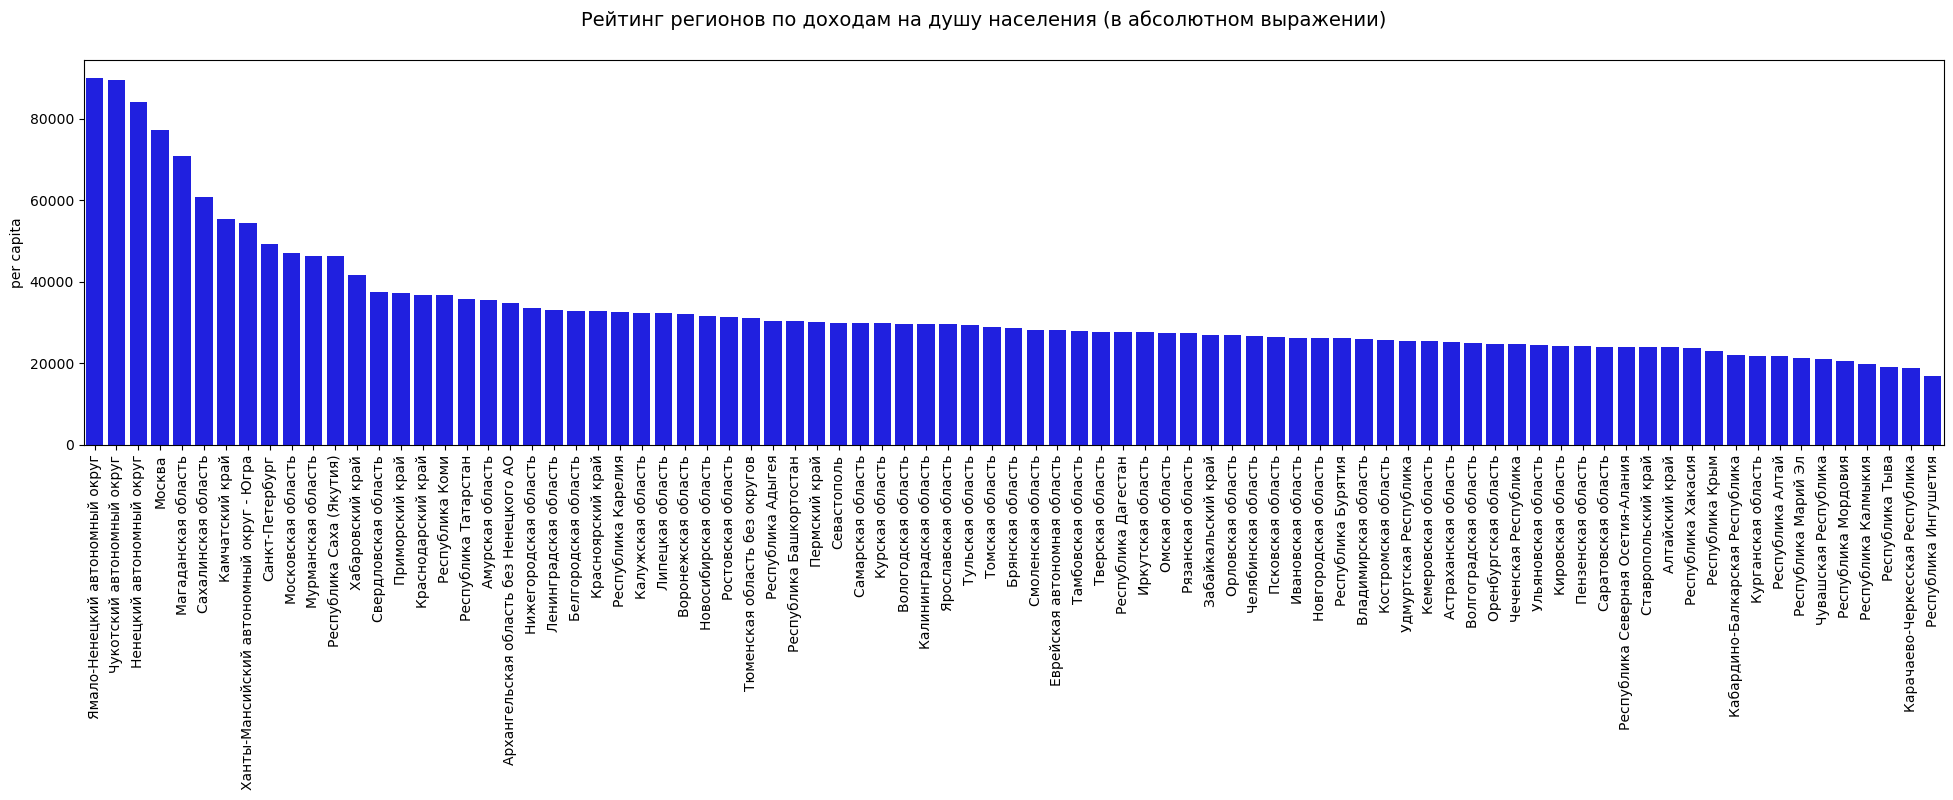

In [33]:
plot_df = model_df.sort_values(by='per capita', ascending=False)
fig = plt.figure(figsize=(24,5))
sns.barplot(data=plot_df, x=plot_df.index, y='per capita', color="b")
fig.suptitle(
    'Рейтинг регионов по доходам на душу населения (в абсолютном выражении)',
    fontsize=14);
plt.xlabel('')
plt.xticks(rotation = 90);
plt.savefig('data/social_russia_data/figs_3d/per_capita.png')

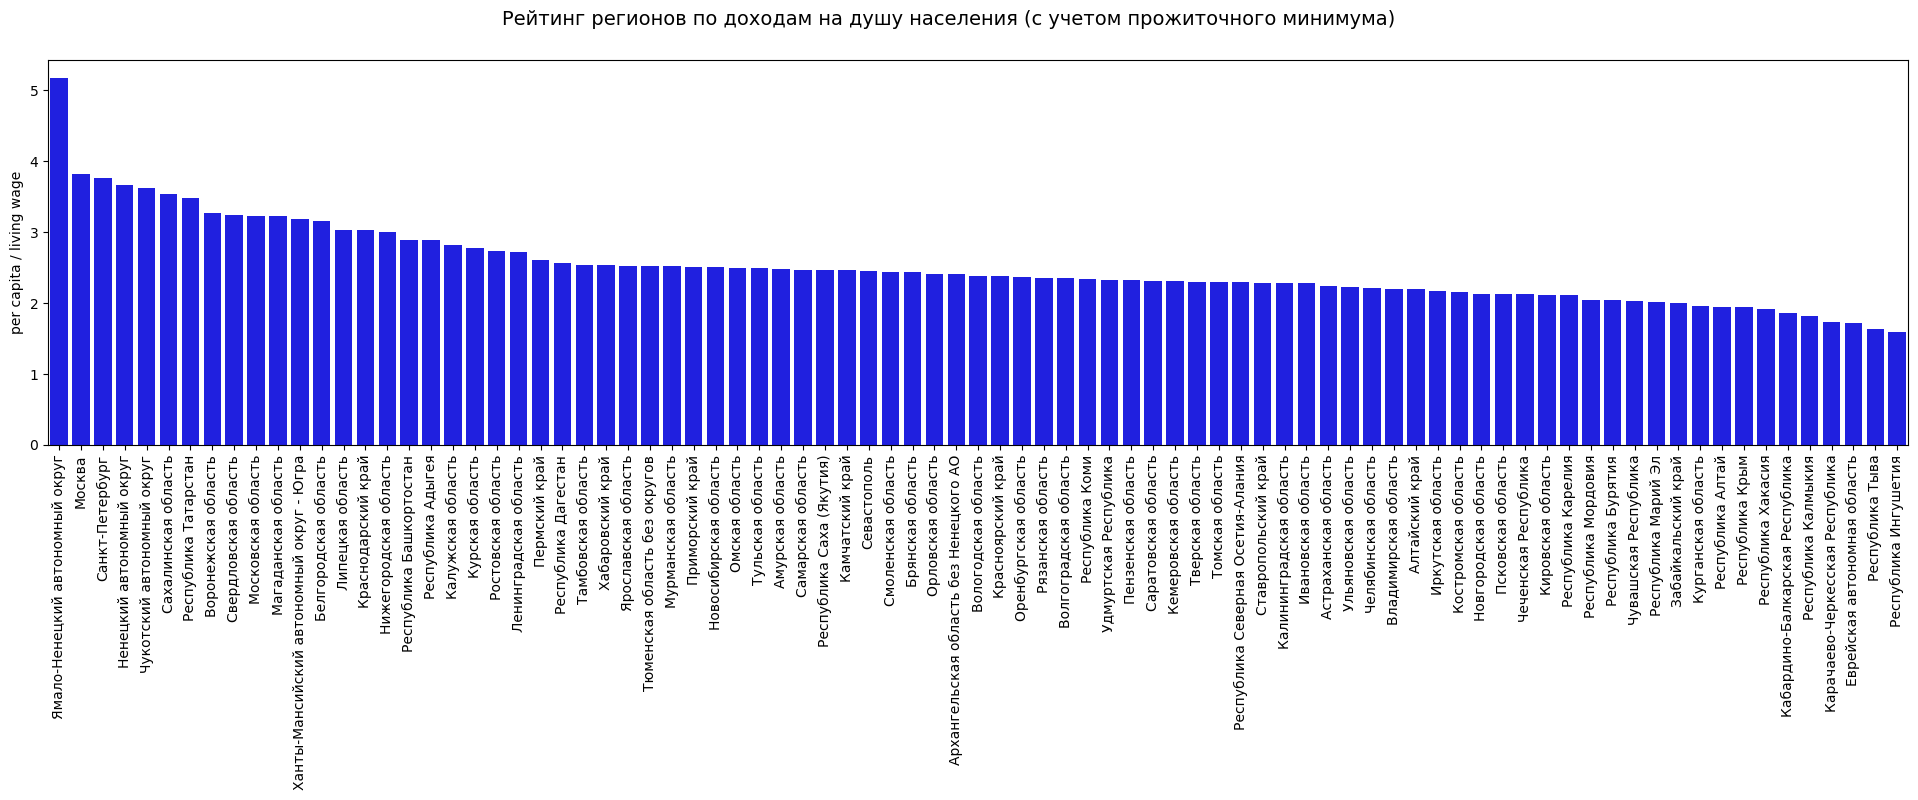

In [34]:
plot_df['per capita norm'] = plot_df['per capita'] / plot_df['living wage']
plot_df.sort_values(by='per capita norm', ascending=False, inplace=True)
fig = plt.figure(figsize=(24,5))
sns.barplot(data=plot_df, x=plot_df.index, y='per capita norm', color="b")
fig.suptitle(
    'Рейтинг регионов по доходам на душу населения (c учетом прожиточного минимума)',
    fontsize=14);
plt.xlabel('')
plt.ylabel('per capita / living wage')
plt.xticks(rotation = 90);
plt.savefig('data/social_russia_data/figs_3d/per_capita_norm.png')

Наблюдается заметная разница между верхними и нижними строчками рейтинга при абсолютном и относительном выражении. Общая тенденция после нормировки сохраняется, однако второй график выглядит более сглаженным и лучше отражающим реальное положение дел: например, на первом графике Москва оказывается на 4-м, а Санкт-Петербург на 9-м месте, в то время как на втором графике главные города страны занимают соответственно 2-е и 3-е места.

### Антирейтинг регионов по уровню бедности.

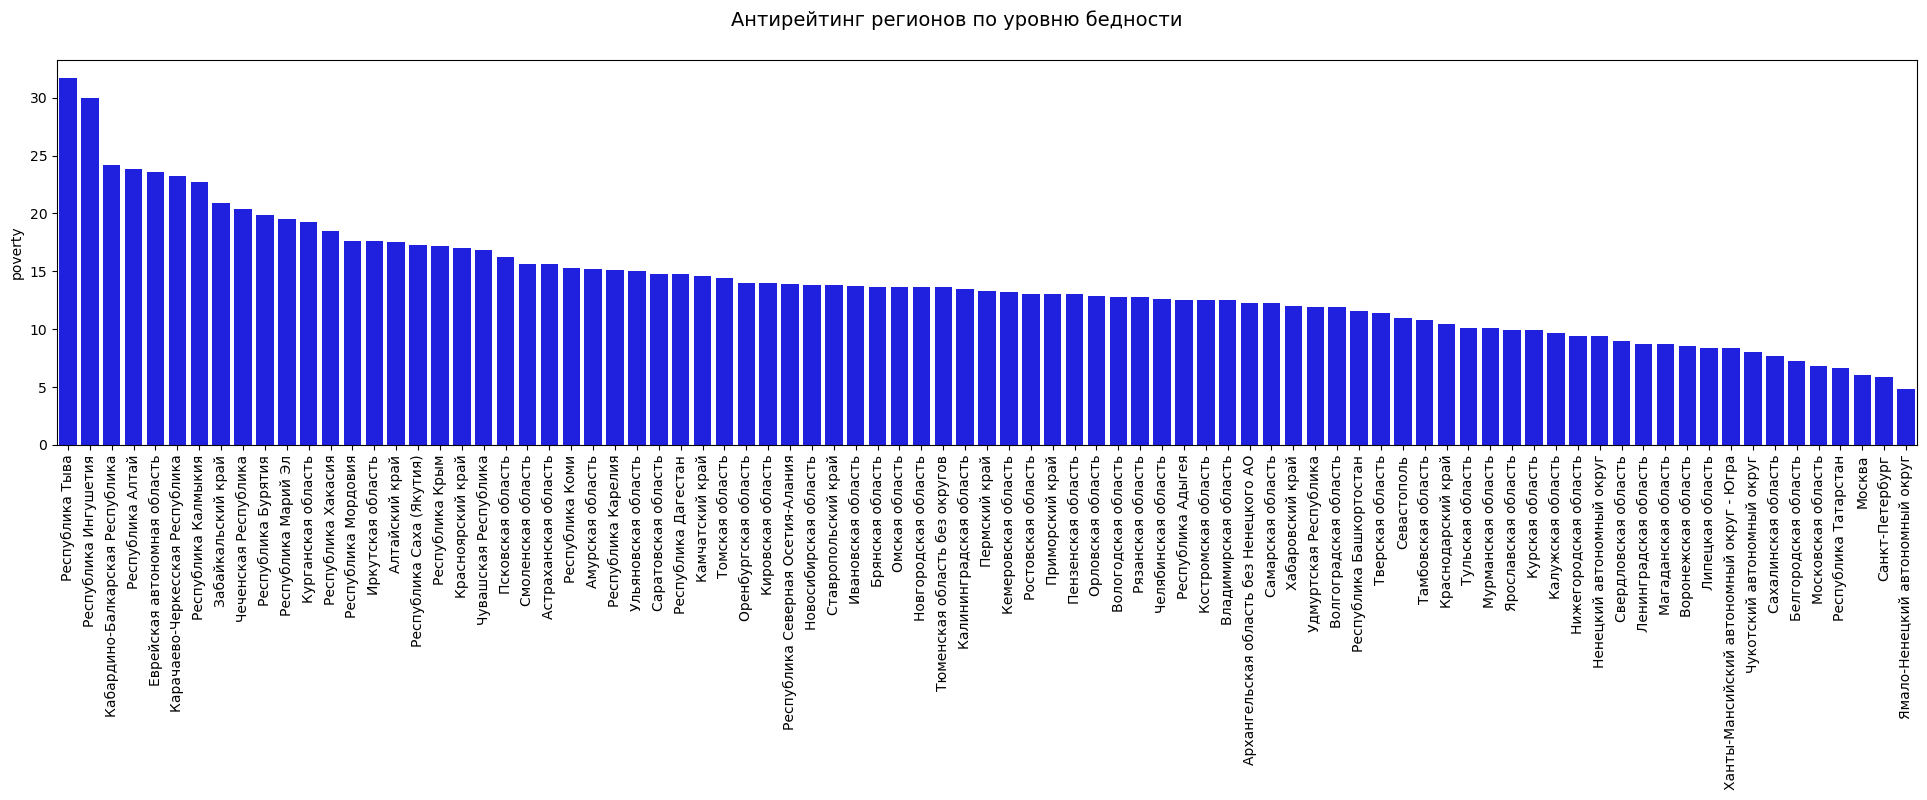

In [35]:
plot_df.sort_values(by='poverty', ascending=False, inplace=True)
fig = plt.figure(figsize=(24,5))
sns.barplot(data=plot_df, x=plot_df.index, y='poverty', color="b")
fig.suptitle(
    'Антирейтинг регионов по уровню бедности',
    fontsize=14);
plt.xlabel('')
plt.xticks(rotation = 90);
plt.savefig('data/social_russia_data/figs_3d/poverty.png')

### Собственные доходы региональных бюджетов (без дотаций из федерального бюджета). 

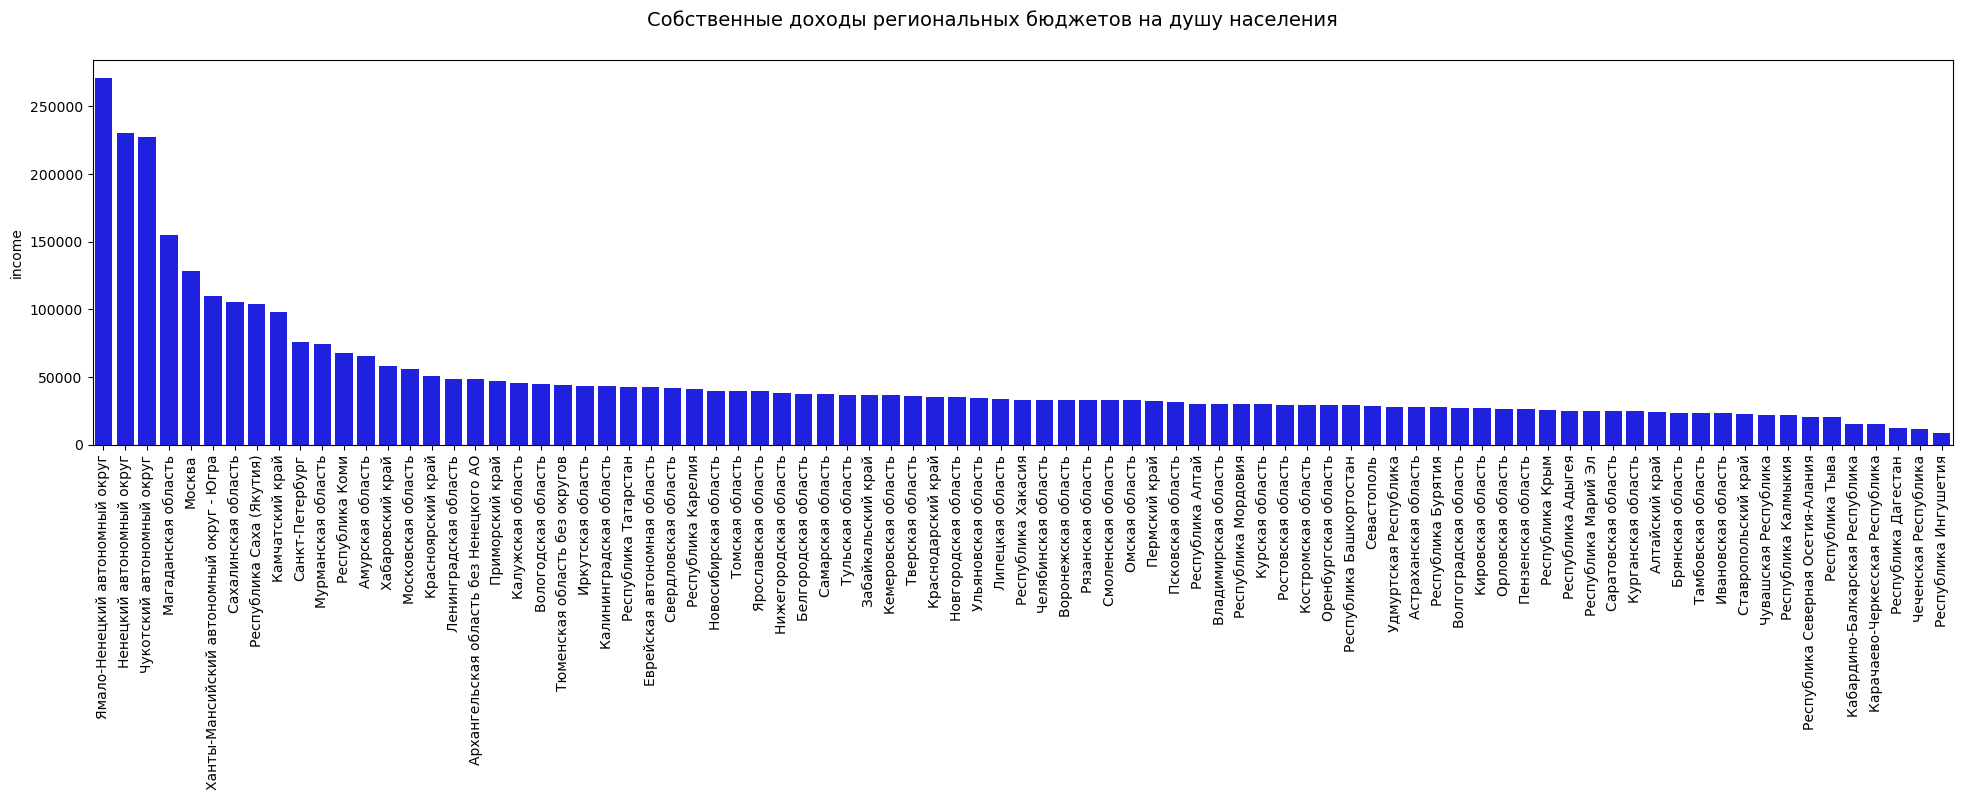

In [36]:
plot_df.sort_values(by='income', ascending=False, inplace=True)
fig = plt.figure(figsize=(24,5))
sns.barplot(data=plot_df, x=plot_df.index, y='income', color="b")
fig.suptitle(
    'Собственные доходы региональных бюджетов на душу населения',
    fontsize=14);
plt.xlabel('')
plt.xticks(rotation = 90);
plt.savefig('data/social_russia_data/figs_3d/income.png')

### Вывод: Данный показатель в некоторой степени отражает потенциальную способность региональных властей обеспечивать социальную политику.

 Однако нужно учесть разницу в уровене расходов на содержание инфраструктуры (в том числе стоимость материалов, доставки в зависимости от территории, географического положения и пр. и увеличенную стоимость на продукты питания) для разных регионов. 
 Детальный учет этих особенностей требует сбора дополнительных данных и разработки отдельной ML-модели, поэтому ограничимся грубым приближением.

### Обеспеченность жилплощадью

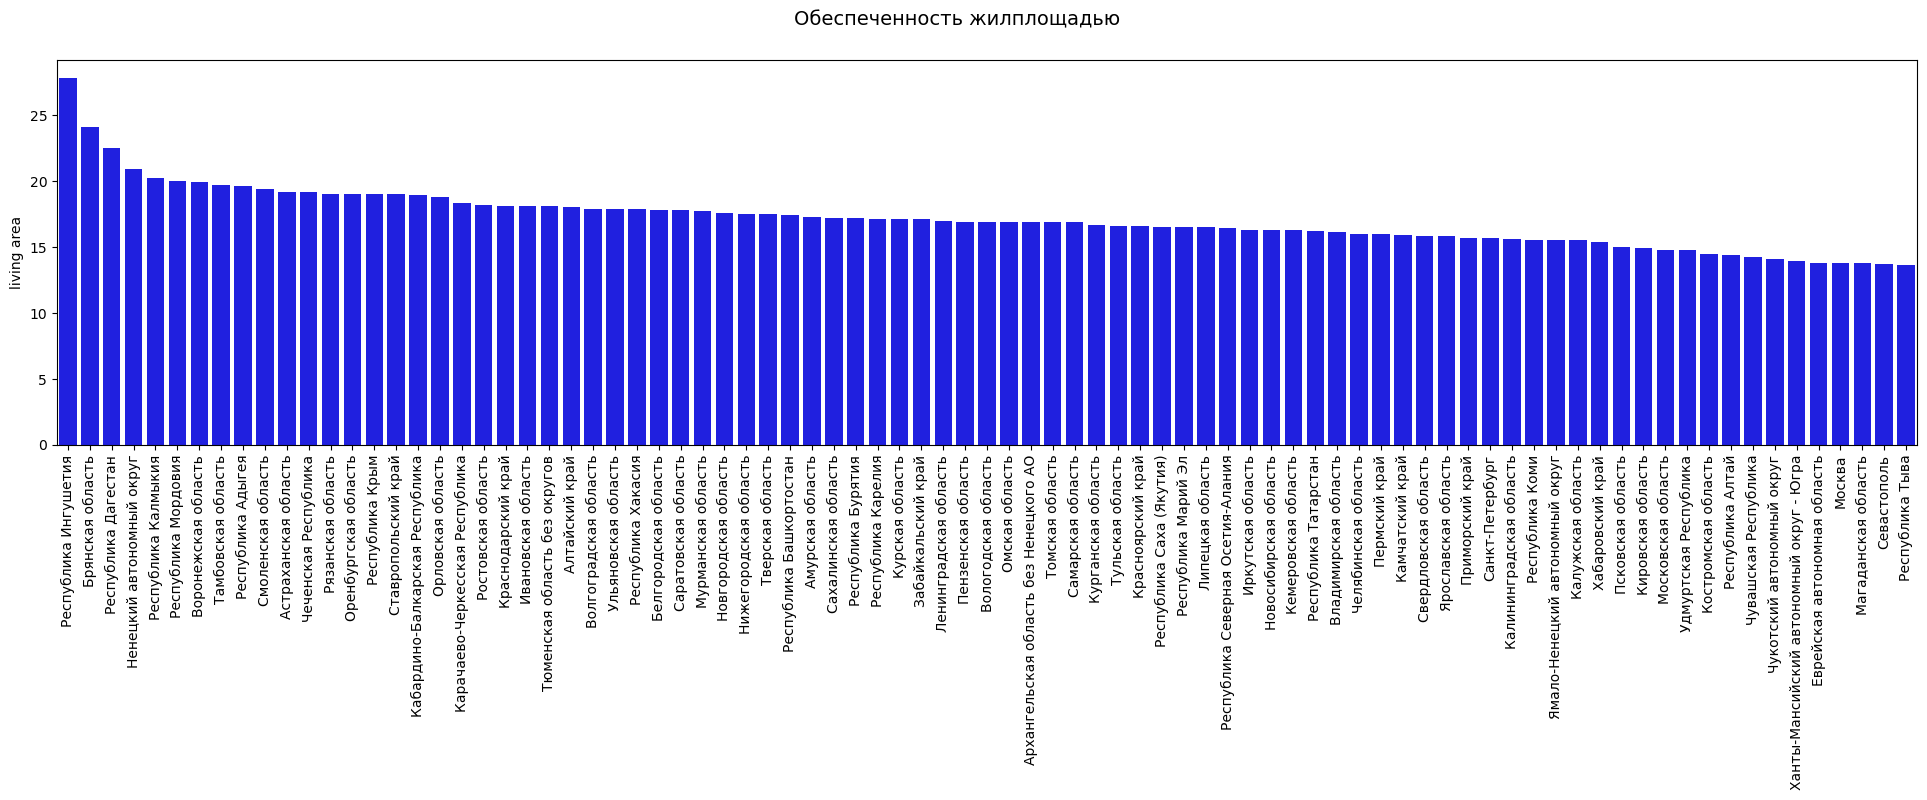

In [37]:
plot_df.sort_values(by='living area', ascending=False, inplace=True)
fig = plt.figure(figsize=(24,5))
sns.barplot(data=plot_df, x=plot_df.index, y='living area', color="b")
fig.suptitle('Обеспеченность жилплощадью', fontsize=14);
plt.xlabel('')
plt.xticks(rotation = 90);
plt.savefig('data/social_russia_data/figs_3d/living_area.png')

### Распределения и преобразования признаков
Изменим DataFrame: нормируем некоторые показатели на прожиточный минимум в регионе.

In [38]:
model_df['per capita norm'] = model_df['per capita'] / model_df['living wage']
model_df['formal wage norm'] = model_df['formal wage'] / model_df['living wage']
model_df['retail norm'] = model_df['retail'] / model_df['living wage']

model_df.drop(columns=['per capita', 'formal wage', 'retail'], axis=1, inplace=True)

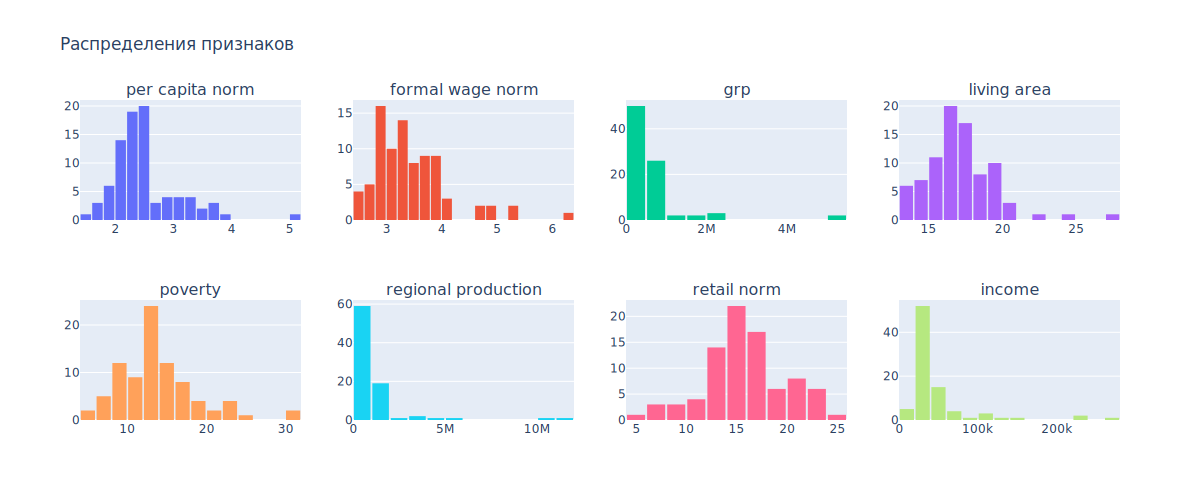

In [39]:
cols = ['per capita norm', 'formal wage norm', 'grp', 'living area', 
        'poverty', 'regional production', 'retail norm', 'income']
fig = make_subplots(rows=2, cols=4, subplot_titles=cols)
fig.add_trace(go.Histogram(x=model_df['per capita norm'], nbinsx=20), row=1, col=1)
fig.add_trace(go.Histogram(x=model_df['formal wage norm'], nbinsx=20), row=1, col=2)
fig.add_trace(go.Histogram(x=model_df['grp'], nbinsx=20), row=1, col=3)
fig.add_trace(go.Histogram(x=model_df['living area'], nbinsx=20), row=1, col=4)
fig.add_trace(go.Histogram(x=model_df['poverty'], nbinsx=20), row=2, col=1)
fig.add_trace(go.Histogram(x=model_df['regional production'], nbinsx=20), row=2, col=2)
fig.add_trace(go.Histogram(x=model_df['retail norm'], nbinsx=20), row=2, col=3)
fig.add_trace(go.Histogram(x=model_df['income'], nbinsx=20), row=2, col=4)
fig.update_layout(title='Распределения признаков', showlegend=False, width=1200, height=500)
fig.layout.bargap = 0.1
fig.show('svg')

Из графиков видно, что признаки 'grp', 'regional production', 'income' распределены не равномерно и их следует преобразовать в логарифмически нормальное распределение. 

Обратим внимание, что в нашем проекте нельзя удалять выбросы (экстремальные значения), т.к. имеющиеся численные оценки носят объективный характер, и соответственно отбрасывать некоторые регионы нельзя с точки зрения достижения целей проекта, а приведение экстремальных значений к медиане значительно исказят объективную картину.

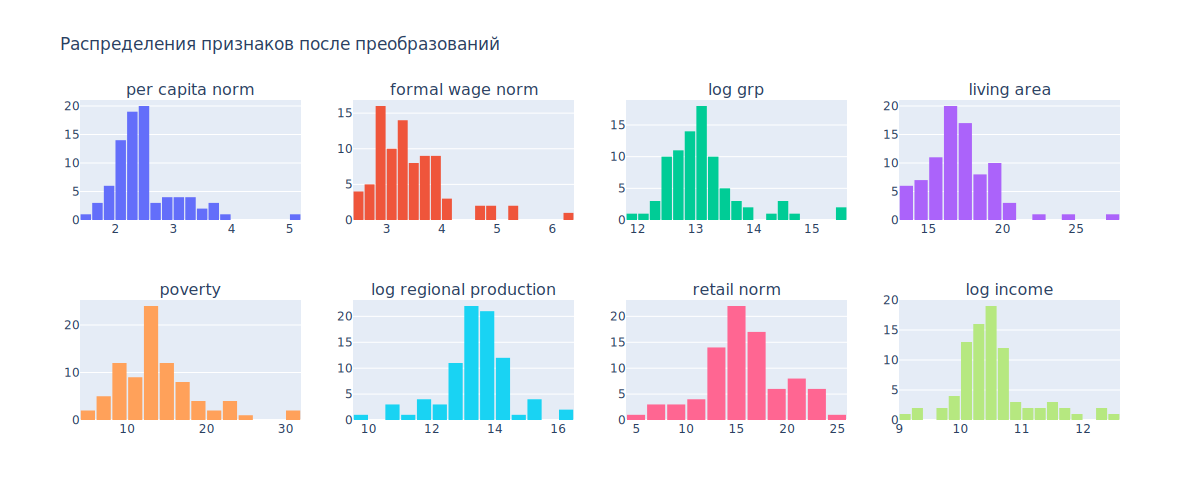

In [40]:
model_df['log grp'] = np.log(model_df['grp'])
model_df['log regional production'] = np.log(model_df['regional production'])
model_df['log income'] = np.log(model_df['income'])
model_df.drop(columns=['grp', 'regional production', 'income'], axis=1, inplace=True)

cols = ['per capita norm', 'formal wage norm', 'log grp', 'living area', 
        'poverty', 'log regional production', 'retail norm', 'log income']
fig = make_subplots(rows=2, cols=4, subplot_titles=cols)
fig.add_trace(go.Histogram(x=model_df['per capita norm'], nbinsx=20), row=1, col=1)
fig.add_trace(go.Histogram(x=model_df['formal wage norm'], nbinsx=20), row=1, col=2)
fig.add_trace(go.Histogram(x=model_df['log grp'], nbinsx=20), row=1, col=3)
fig.add_trace(go.Histogram(x=model_df['living area'], nbinsx=20), row=1, col=4)
fig.add_trace(go.Histogram(x=model_df['poverty'], nbinsx=20), row=2, col=1)
fig.add_trace(go.Histogram(x=model_df['log regional production'], nbinsx=20), row=2, col=2)
fig.add_trace(go.Histogram(x=model_df['retail norm'], nbinsx=20), row=2, col=3)
fig.add_trace(go.Histogram(x=model_df['log income'], nbinsx=20), row=2, col=4)
fig.update_layout(title='Распределения признаков после преобразований', showlegend=False, width=1200, height=500)
fig.layout.bargap = 0.1
fig.show('svg')
fig.write_image('data/social_russia_data/figs_3d/svg.png')

Упорядочим данные после преобразований

In [41]:
cols = ['per capita norm', 'formal wage norm', 'log grp', 
        'log regional production', 'log income', 'retail norm', 
        'living area', 'poverty']
model_df = model_df[cols].copy()

In [42]:
for col in model_df.columns:
    _, p = shapiro(model_df[col])
    print(f'{col}:   p-value = {p:.3f}')

per capita norm:   p-value = 0.000
formal wage norm:   p-value = 0.000
log grp:   p-value = 0.000
log regional production:   p-value = 0.002
log income:   p-value = 0.000
retail norm:   p-value = 0.597
living area:   p-value = 0.000
poverty:   p-value = 0.000


Тест Шапиро на нормальность распределения показывает, что только признак 'retail norm' (розничная торговля) можно считать нормально распределенным (p-value = 0.597).

### Корреляции, мультиколлинеарность
Корреляционная матрица. 

Ввиду того, что распределения данных далеки от нормальных, рассмотрим ранговые критерии Спирмена и Кендалла.

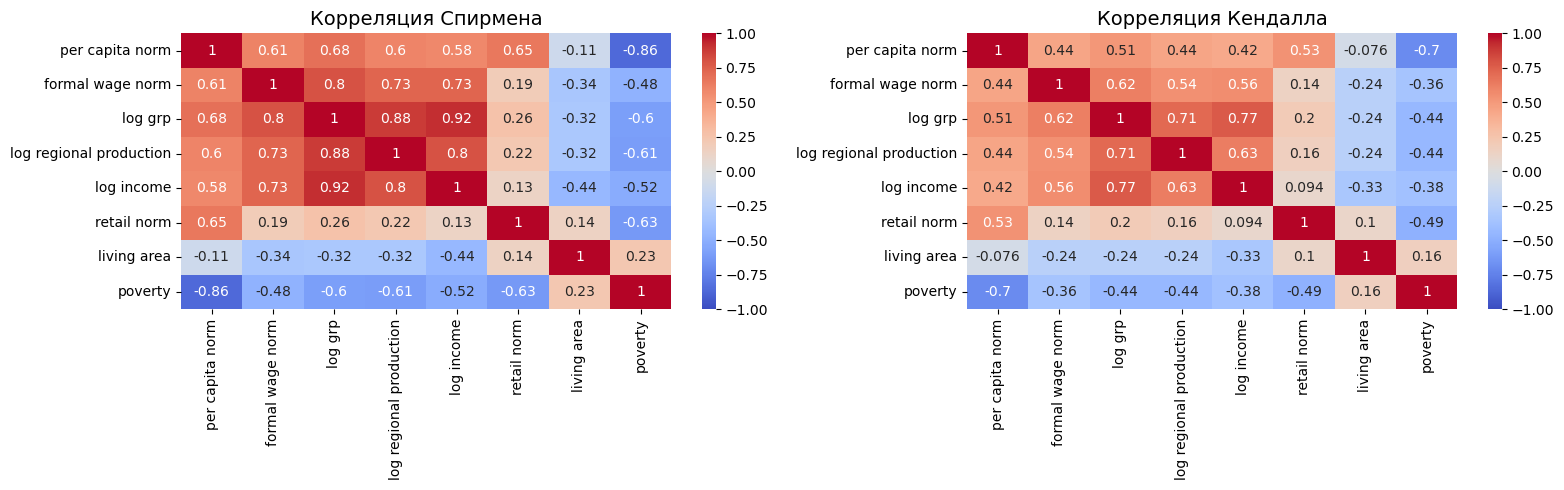

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
sns.heatmap(model_df.corr(method='spearman'), 
            annot=True, cmap='coolwarm', vmin=-1, ax=ax[0])
sns.heatmap(model_df.corr(method='kendall'), 
            annot=True, cmap='coolwarm', vmin=-1, ax=ax[1])
ax[0].set_title('Корреляция Спирмена', fontsize=14)
ax[1].set_title('Корреляция Кендалла', fontsize=14)
plt.tight_layout();

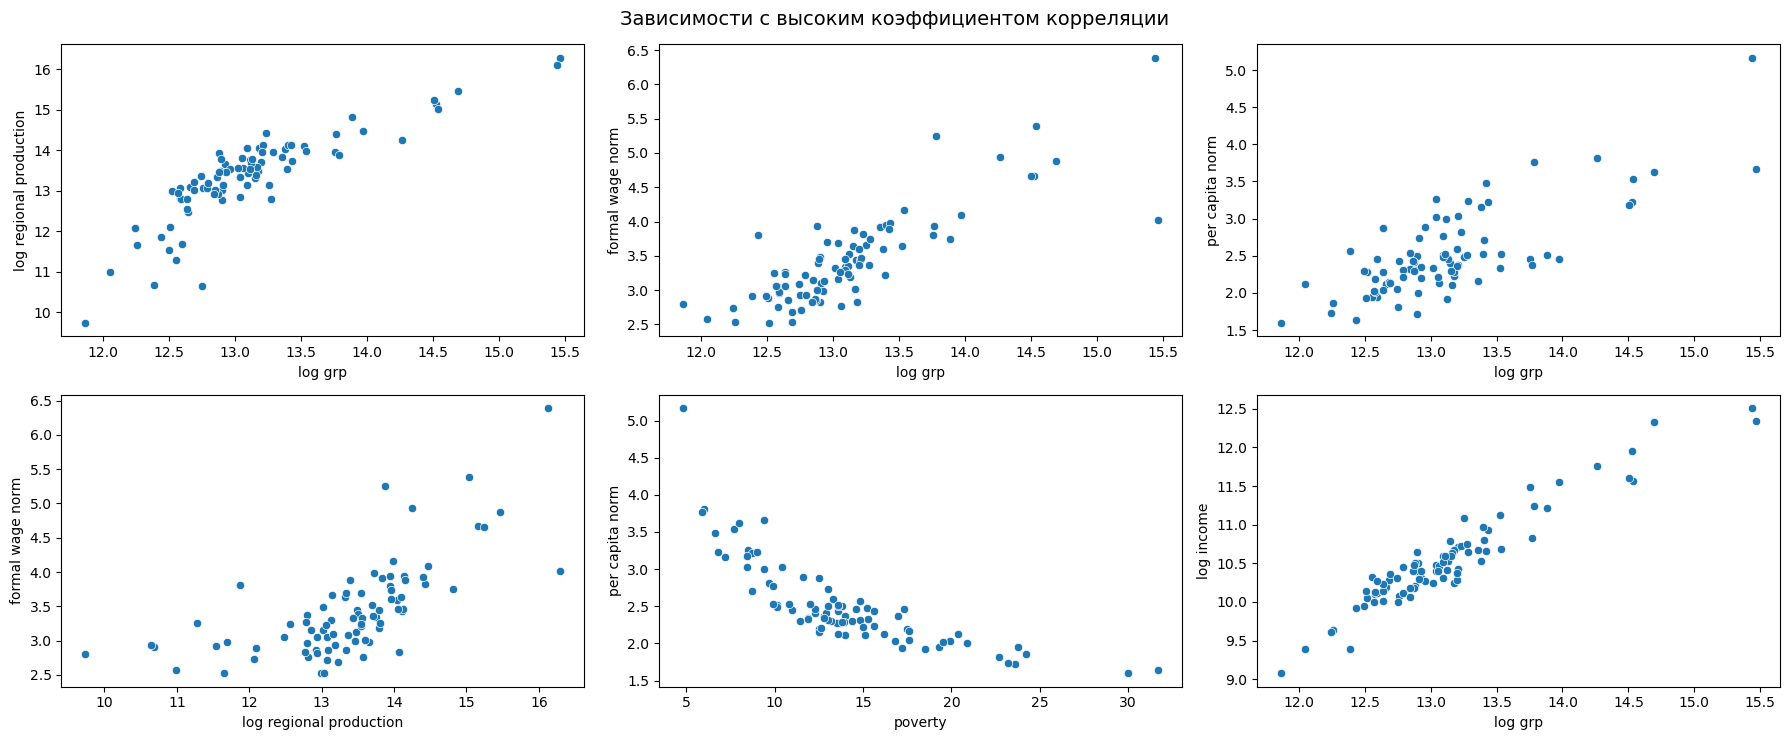

In [44]:
fig, ax = plt.subplots(2, 3, figsize=(18, 7.5))
sns.scatterplot(data=model_df, x= 'log grp', y ='log regional production', ax=ax[0, 0])
sns.scatterplot(data=model_df, x= 'log grp', y ='formal wage norm', ax=ax[0, 1])
sns.scatterplot(data=model_df, x= 'log grp', y ='per capita norm', ax=ax[0, 2])
sns.scatterplot(data=model_df, x= 'log regional production', y ='formal wage norm', ax=ax[1, 0])
sns.scatterplot(data=model_df, x= 'poverty', y ='per capita norm', ax=ax[1, 1])
sns.scatterplot(data=model_df, x= 'log grp', y ='log income', ax=ax[1, 2])
plt.suptitle('Зависимости с высоким коэффициентом корреляции', fontsize=14)
plt.tight_layout();
plt.savefig('data/social_russia_data/figs_3d/zav_cor.png')

***Выводы:*** Некоторые из зависимостей ожидаемы: валовый региональный продукт прямо связан с производством в регионе, а уровень бедности - с доходом на душу населения. 
На основании этого исключим признаки-"дубли". Оставим часть признаков, где связь не столь явная. Также мы отсекаем признаки, скоррелированные по критерию Кендалла (corr $\ge+0.7, \le-0.7$). 


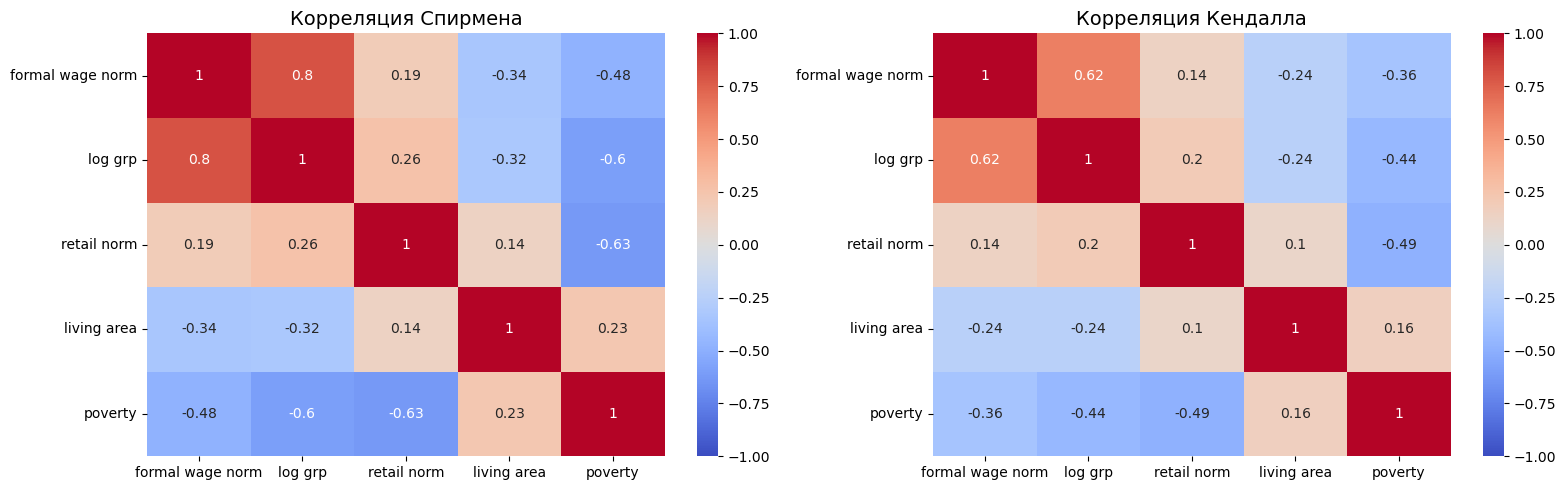

In [45]:
model_df.drop(
    columns=['log regional production', 'per capita norm', 'log income'], 
    axis=1, inplace=True)

fig, ax = plt.subplots(1, 2, figsize=(16, 5))
sns.heatmap(model_df.corr(method='spearman'), 
            annot=True, cmap='coolwarm', vmin=-1, ax=ax[0])
sns.heatmap(model_df.corr(method='kendall'), 
            annot=True, cmap='coolwarm', vmin=-1, ax=ax[1])
ax[0].set_title('Корреляция Спирмена', fontsize=14)
ax[1].set_title('Корреляция Кендалла', fontsize=14)
plt.tight_layout();
plt.savefig('data/social_russia_data/figs_3d/cor.png')

## Масштабирование
Масштабируем признаки по минимальным и максимальным значениям.

In [46]:
scaler = MinMaxScaler()
X = scaler.fit_transform(model_df)

### 2.2. Кластеризация
### Базовая модель: k-means
В качестве базовой модели используем k-means. Выбираем количество кластеров.

c:\Users\konstantinov.oleg\AppData\Local\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\konstantinov.oleg\AppData\Local\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\konstantinov.oleg\AppData\Local\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\konstantinov.oleg\AppData\Local\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: U

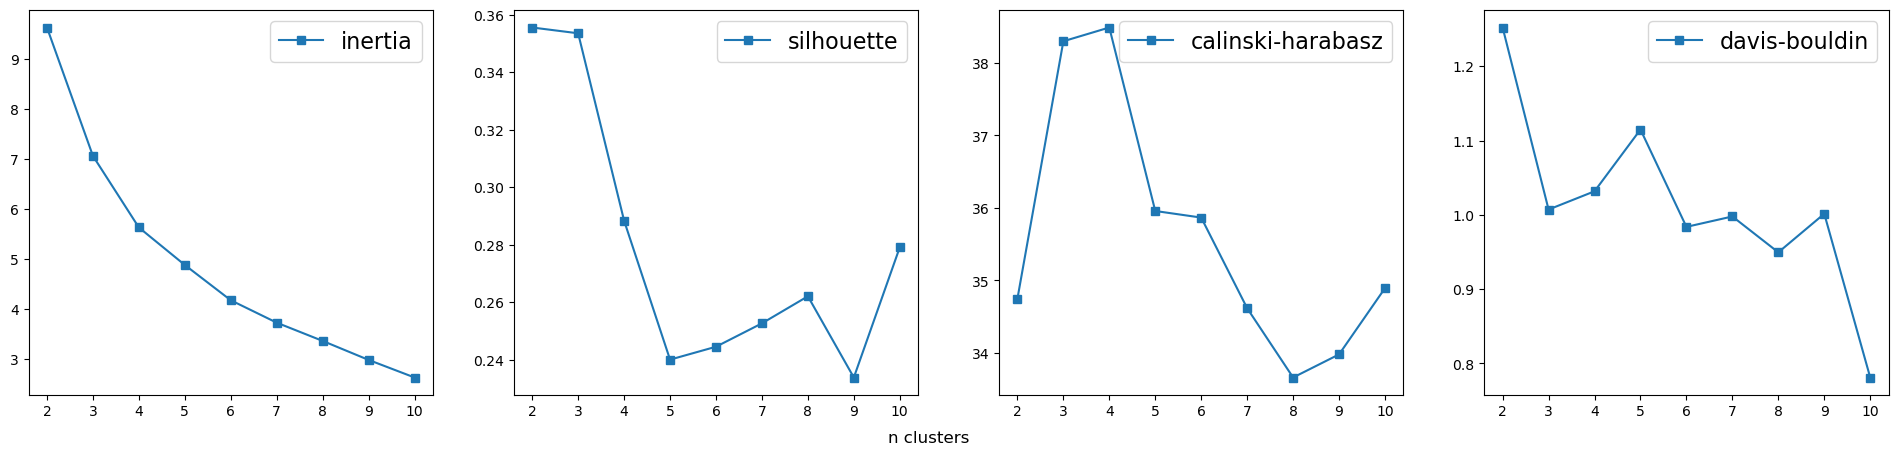

In [47]:
def plot_metrics(X):
    #Построение графиков кластеризации в зависимости от количества кластеров
    inertia = []
    silhouette = []
    calinski_harabasz = []
    davis_bouldin = []
    
    for n_cl in range(2, 11):
        kmeans = cluster.KMeans(n_clusters=n_cl, random_state=42)
        kmeans.fit(X)
    
        inertia.append(kmeans.inertia_)
        silhouette.append(metrics.silhouette_score(
            X, kmeans.labels_))
        calinski_harabasz.append(metrics.calinski_harabasz_score(
            X, kmeans.labels_))
        davis_bouldin.append(metrics.davies_bouldin_score(
            X, kmeans.labels_))
        
    fig, ax = plt.subplots(1, 4, figsize=(24,5))
    
    ax[0].plot(range(2, 11), inertia, 's-', label='inertia')
    ax[1].plot(range(2, 11), silhouette, 's-', label='silhouette')
    ax[2].plot(range(2, 11), calinski_harabasz, 's-', label='calinski-harabasz')
    ax[3].plot(range(2, 11), davis_bouldin, 's-', label='davis-bouldin')
    ax[0].legend(prop={'size': 16})
    ax[1].legend(prop={'size': 16})
    ax[2].legend(prop={'size': 16})
    ax[3].legend(prop={'size': 16});
    fig.supxlabel('n clusters')
    fig.savefig('data/social_russia_data/figs_3d/n_clusters')
    
        
plot_metrics(X)

Разделение кластеров нечеткое (коэффициент силуэта везде меньше 0.4, наибольшее значение при минимальном количестве кластеров). Тем не менее, ориентируясь на метод локтя (inertia) и индекс Сalinski-Harabasz, можно принять количество кластеров n = 4. В качестве графического представления результатов кластеризации используем t-SNE преобразование пятимерного признакового пространства на плоскость. Выводим значения метрик качества кластеризации.

c:\Users\konstantinov.oleg\AppData\Local\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



Silhouette: 0.288
Calinski-Harabatz: 38.489
Davis-Bouldin: 1.032


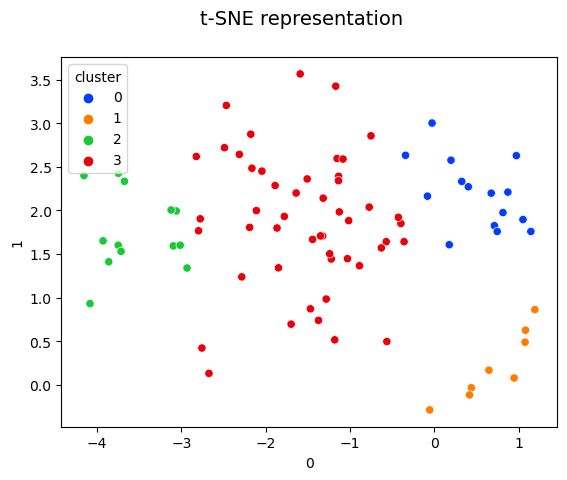

In [48]:
def plot_results(X, labels):
    # Построение двумерного представления tSNE и вычисленных показателей
    tsne = TSNE(n_components=2, perplexity=50, init='pca',
                learning_rate='auto', random_state=42)
    df_tsne = pd.DataFrame(tsne.fit_transform(X))
    df_tsne['cluster'] = labels
    fig = plt.figure()
    sns.scatterplot(x=df_tsne[0], y=df_tsne[1],
                    hue=df_tsne['cluster'], palette='bright')
    fig.suptitle('t-SNE representation', fontsize=14);

    print('Silhouette: {:.3f}'.format(metrics.silhouette_score(X, labels)))
    print('Calinski-Harabatz: {:.3f}'.format(metrics.calinski_harabasz_score(X, labels)))
    print('Davis-Bouldin: {:.3f}'.format(metrics.davies_bouldin_score(X, labels)))
        

kmeans = cluster.KMeans(n_clusters=4, random_state=42)
bm_labels = kmeans.fit_predict(X)
plot_results(X, bm_labels)

### Понижение размерности. PCA + k-means

Число главных компонент: 3


c:\Users\konstantinov.oleg\AppData\Local\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\konstantinov.oleg\AppData\Local\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\konstantinov.oleg\AppData\Local\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\konstantinov.oleg\AppData\Local\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: U

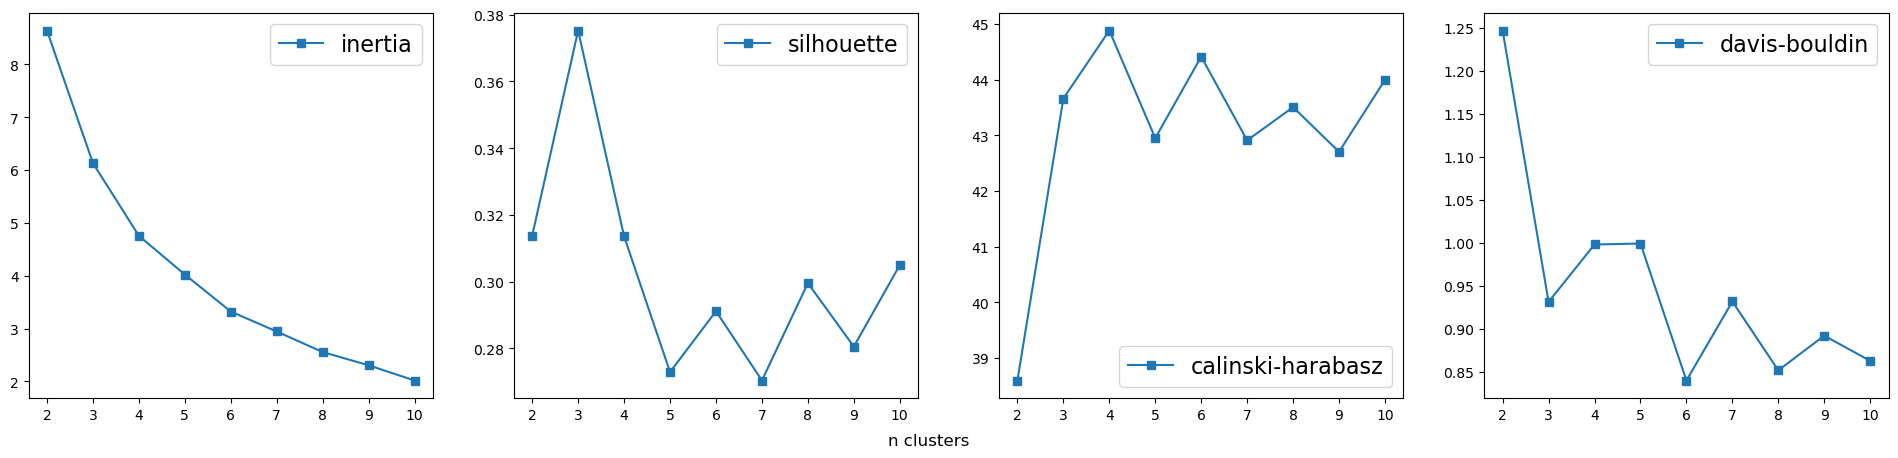

In [49]:
pca = PCA(n_components=0.9)  # 90% of explained dispersion
X_pca = pca.fit_transform(X)
print(f'Число главных компонент: {pca.n_components_}')

plot_metrics(X_pca)

Коэффициент силуэта показывает максимум при количестве кластеров n=3, однако по методу локтя и коэффициенту Сalinski-Harabasz лучше оставить n=4. 
При этом метрики показывают лучшее качество, чем у базовой модели.

c:\Users\konstantinov.oleg\AppData\Local\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



Silhouette: 0.314
Calinski-Harabatz: 44.883
Davis-Bouldin: 0.998
Rand score (сравнение с базовой моделью): 0.948739


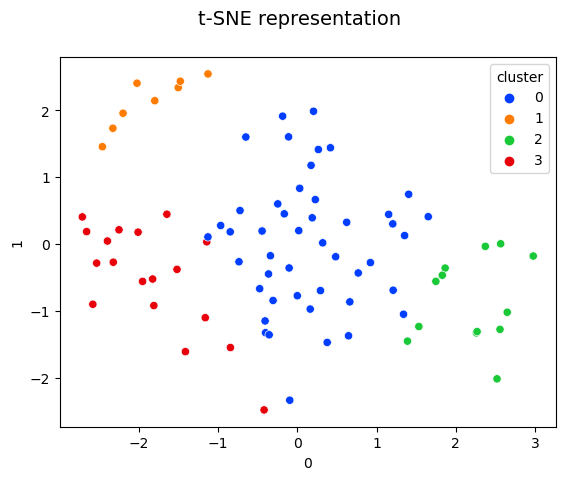

In [50]:
kmeans_pca = cluster.KMeans(n_clusters=4, random_state=42)
kmeans_pca.fit_predict(X_pca)
plot_results(X_pca, kmeans_pca.labels_)
print('Rand score (сравнение с базовой моделью): {:3f}'.format(metrics.rand_score(bm_labels, kmeans_pca.labels_)))

Визуализируем результат кластеризации непосредственно в пространстве трех главных компонент.

In [51]:
fig = px.scatter_3d(
    x=X_pca[:,0], y=X_pca[:,1], z=X_pca[:,2],
    title='Кластеры в пространстве трех главных компонент (PCA)',
    color=kmeans_pca.labels_, width=650, height=400)
fig.update_traces(marker={'size':3}, marker_line_width=0.5)
fig.show()
fig.write_image('data/social_russia_data/figs_3d/kmeans_pca.png')

### Тестирование различных алгоритмов кластеризации, валидация

c:\Users\konstantinov.oleg\AppData\Local\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



Silhouette: 0.326
Calinski-Harabatz: 41.354
Davis-Bouldin: 0.843
Rand score (сравнение с базовой моделью): 0.831933


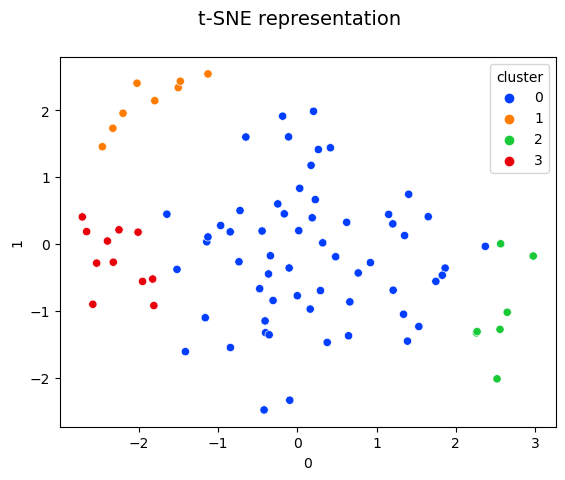

In [52]:
# Гауссова смесь, наилучший вариант: covariance_type='tied'
gmix = GaussianMixture(
    n_components=4, random_state=42, covariance_type='tied')
labels = gmix.fit_predict(X_pca)
plot_results(X_pca, labels)
print('Rand score (сравнение с базовой моделью): {:3f}'
    .format(metrics.rand_score(bm_labels, labels)))

Silhouette: 0.301
Calinski-Harabatz: 42.464
Davis-Bouldin: 0.971
Rand score (сравнение с базовой моделью): 0.901681


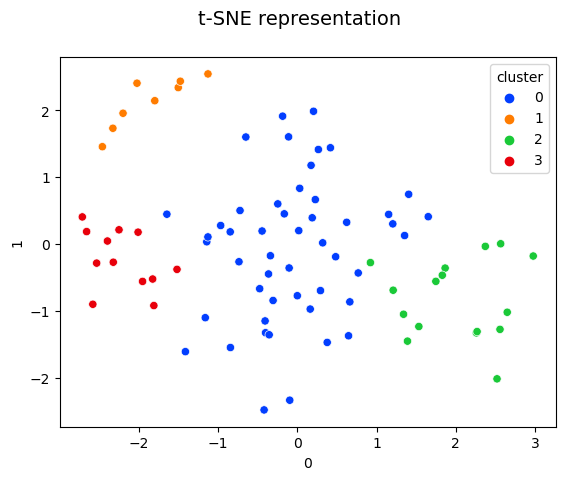

In [53]:
# Агломеративная кластеризация, наилучший вариант: linkage='ward'
tree_like = cluster.AgglomerativeClustering(n_clusters=4, linkage='ward')
labels = tree_like.fit_predict(X_pca)
plot_results(X_pca, labels)
print('Rand score (сравнение с базовой моделью): {:3f}'
    .format(metrics.rand_score(bm_labels, labels)))

Silhouette: 0.398
Calinski-Harabatz: 41.350
Davis-Bouldin: 0.906
Rand score (сравнение с базовой моделью): 0.752101


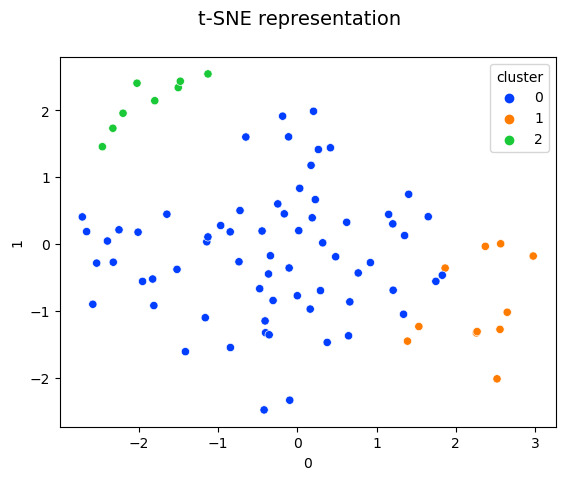

In [54]:
# Распространение сходства
aff_prop = cluster.AffinityPropagation(damping=0.9, random_state=42)
labels = aff_prop.fit_predict(X_pca)
plot_results(X_pca, labels)
print('Rand score (сравнение с базовой моделью): {:3f}'
    .format(metrics.rand_score(bm_labels, labels)))

c:\Users\konstantinov.oleg\AppData\Local\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



Silhouette: 0.263
Calinski-Harabatz: 39.150
Davis-Bouldin: 1.084
Rand score (сравнение с базовой моделью): 0.669468


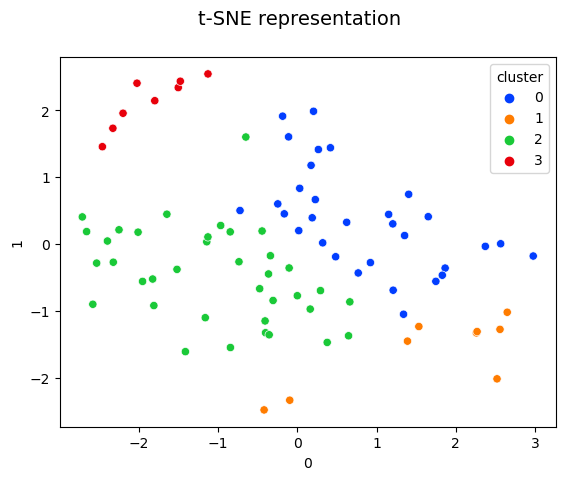

In [55]:
spectral = cluster.SpectralClustering(n_clusters=4)
labels = spectral.fit_predict(X_pca)
plot_results(X_pca, labels)
print('Rand score (сравнение с базовой моделью): {:3f}'
    .format(metrics.rand_score(bm_labels, labels)))

### Выводы:

Гауссова смесь показывает наилучшие метрики (коэффициент силуэта и индекс Davies-Bouldin). Наилучший коэффициент Calinski-Harabatz у метода k-means на PCA-признаках. Ориентируясь на два индекса и визуализацию результата кластеризации в пространстве PCA-компонент (ниже), в качестве окончательной модели выбираем "гауссову смесь на PCA-компонентах". Отметим, что в качестве альтернативного метода разбиения выборки на кластеры можно использовать k-means, который дает несколько более равномерное разбиение и большее количество неблагополучных регионов.

Также отметим, что индексы Рэнда при сравнении с базовой моделью остаются достаточно высокими, что говорит об устойчивости общей структуры распределения объектов по кластерам при использовании разных алгоритмов. Вариации индекса Рэнда объясняются различными перераспределениями "граничных" (между кластерами) точек. Это хорошо демонстрируется визуализацией результатов с посщью tSNE, а также в трехмерном пространстве PCA-компонент.

In [56]:
# Гауссова смесь, наилучший вариант: covariance_type='tied'
gmix = GaussianMixture(
    n_components=4, random_state=42, covariance_type='tied')
labels_gmix = gmix.fit_predict(X_pca)
df['cluster'] = labels_gmix

# Упорядочим нумерацию кластеров 
df['cluster'] = df['cluster'].replace({2:0, 0:1, 3:2, 1:3})
df.to_csv('data/social_russia_data/russia_regions_2020_clusters.csv')
df['cluster'].to_csv('data/social_russia_data/labels.csv')

fig = px.scatter_3d(
    x=X_pca[:,0], y=X_pca[:,1], z=X_pca[:,2],
    title='Кластеры в пространстве трех главных компонент (PCA)',
    color=df['cluster'], width=650, height=400)
fig.update_traces(marker={'size':3}, marker_line_width=0.5)
fig.show()
fig.write_image('data/social_russia_data/figs_3d/gmix_pca.png')

c:\Users\konstantinov.oleg\AppData\Local\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



In [57]:
df

,per capita,formal wage,child mortality,disabled 18_60,alco (2018),drug (2018),grp,living area,bad conditions,no funds,...,misdemeanors,killed,grievous harm,children %,orphanage,adopted %,pension,retired %,living wage,cluster
region,,,,,,,,,,,,,,,,,,,,,
Алтайский край,23864.0,30072.0,0.485583,5.093525,88.1,17.4,291156.9,18.0,0.3,0.8642,...,8887,411,647,21.153070,983,59.0,16128.19,26.8,10904.0,1
Амурская область,35499.0,52430.0,0.534827,5.766846,113.3,24.4,571362.1,17.3,1.3,1.0731,...,4967,223,255,22.619247,676,65.0,17998.70,22.4,14331.0,1
Архангельская область без Ненецкого АО,34852.0,52779.0,0.325623,4.674270,64.7,9.2,514200.4,16.9,1.4,1.2998,...,4569,166,288,20.708809,785,60.0,21753.88,26.4,14507.0,1
Астраханская область,25199.0,38885.0,0.586564,3.632293,22.2,0.2,526950.9,19.2,0.8,2.9028,...,2818,93,169,22.620409,376,66.0,15427.85,23.9,11287.0,1
Белгородская область,32841.0,37442.0,0.380505,7.250936,41.3,3.2,646569.0,17.8,0.7,0.3840,...,3208,159,249,18.764730,219,82.0,17438.93,27.2,10403.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Чеченская Республика,24596.0,29771.0,0.601109,17.854091,4.1,0.6,171029.5,19.2,0.6,0.5539,...,717,24,21,37.089495,0,100.0,16165.00,10.3,11572.0,0
Чувашская Республика,21155.0,31844.0,0.212258,4.385201,79.0,1.2,287210.3,14.2,1.2,1.8768,...,3418,141,188,21.259663,161,77.0,16111.97,24.9,10414.0,1
Чукотский автономный округ,89541.0,120641.0,1.489758,3.515586,208.7,0.0,2404271.2,14.1,1.9,0.0000,...,167,28,20,25.099427,60,69.0,30144.56,14.5,24711.0,3


## Вывод
Из ранее подготовленного DataFrame по российским регионам в качестве критериев для последующей их группировки в кластеры с близкими параметрами выбраны признаки, отражающие социально-экономическое благополучие субъектов федерации. Построены рейтинги регионов по избранным показателям. Исследованы распределения выбранных признаков и корреляции между ними, произведен отбор и выполнены необходимые преобразования. Итоговый модельный датасет для проведения кластеризации включает в себя 5 независимых характеристик:

* номинальную заработную плату, нормированную на прожиточный минимум в регионе;
* валовый региональный продукт в логарифмической шкале;
* объем розничной торговли на человека, нормированный на прожиточный минимум в регионе;
* жилую площадь на человека;
* процент населения за чертой бедности.

С помощью различных внутренних метрик кластеризации оценено оптимальное количество кластеров (четыре). Построена базовая модель (k-means). Выполнено PCA-понижение размерности (3 главных компоненты, объясняющие 90% дисперсии). Проверены разные алгоритмы кластеризации, выбран оптимальный ("гауссова смесь на PCA-компонентах"), регионам присвоены соответствующие метки. Продемонстрирована устойчивость общей структуры кластеров при использовании различных алгоритмов кластеризации. При необходимости в качестве альтернативы можно также использовать k-means на PCA-компонентах, дающий похожие значения метрик и несколько большее число финансово неблагополучных регионов.

## Часть 3. Анализ результатов кластеризации

In [58]:
# Загружаем DataFrame
df = russia_regions_2020
df.head(3)

,per capita,formal wage,child mortality,disabled 18_60,alco (2018),drug (2018),grp,living area,bad conditions,no funds,...,misdemeanors,killed,grievous harm,children %,orphanage,adopted %,pension,retired %,living wage,cluster
region,,,,,,,,,,,,,,,,,,,,,
Алтайский край,23864.0,30072.0,0.485583,5.093525,88.1,17.4,291156.9,18.0,0.3,0.8642,...,8887,411,647,21.153070,983,59.0,16128.19,26.8,10904.0,1
Амурская область,35499.0,52430.0,0.534827,5.766846,113.3,24.4,571362.1,17.3,1.3,1.0731,...,4967,223,255,22.619247,676,65.0,17998.70,22.4,14331.0,1
Архангельская область без Ненецкого АО,34852.0,52779.0,0.325623,4.674270,64.7,9.2,514200.4,16.9,1.4,1.2998,...,4569,166,288,20.708809,785,60.0,21753.88,26.4,14507.0,1


In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 85 entries, Алтайский край to Ярославская область
Data columns (total 37 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   per capita                      85 non-null     float64
 1   formal wage                     85 non-null     float64
 2   child mortality                 85 non-null     float64
 3   disabled 18_60                  85 non-null     float64
 4   alco (2018)                     85 non-null     float64
 5   drug (2018)                     85 non-null     float64
 6   grp                             85 non-null     float64
 7   living area                     85 non-null     float64
 8   bad conditions                  85 non-null     float64
 9   no funds                        85 non-null     float64
 10  morbidity (2016)                85 non-null     float64
 11  congenital malformation (2016)  85 non-null     float64
 12  psychosis (20

### 3.1 Описание кластеров и их характерные особенности
#### Количество регионов в каждом из 4-х кластеров. 
Большинство регионов ($\sim70\%$) попадают в кластер 1, который, таким образом, можно считать кластером "среднестатистических" российских регионов.

In [60]:
df['cluster'].value_counts().sort_index()

0     7
1    59
2    11
3     8
Name: cluster, dtype: int64

При моделировании, для группировки регионов в соответствии с их социально-экономическим благополучием, были использованы следующие признаки: 
* валовый региональный продукт (grp), 
* среднемесячная заработная плата с учетом прожиточного минимума (formal wage norm), 
* объем розничной торговли в пересчете на человека с учетом прожиточного минимума(retail norm), 
* средний размер жилплощади на человека (living area), уровень бедности (poverty). 

С помощью полярной диаграммы по медианным значениям рассмотрим отличия кластеров по этим характеристикам .

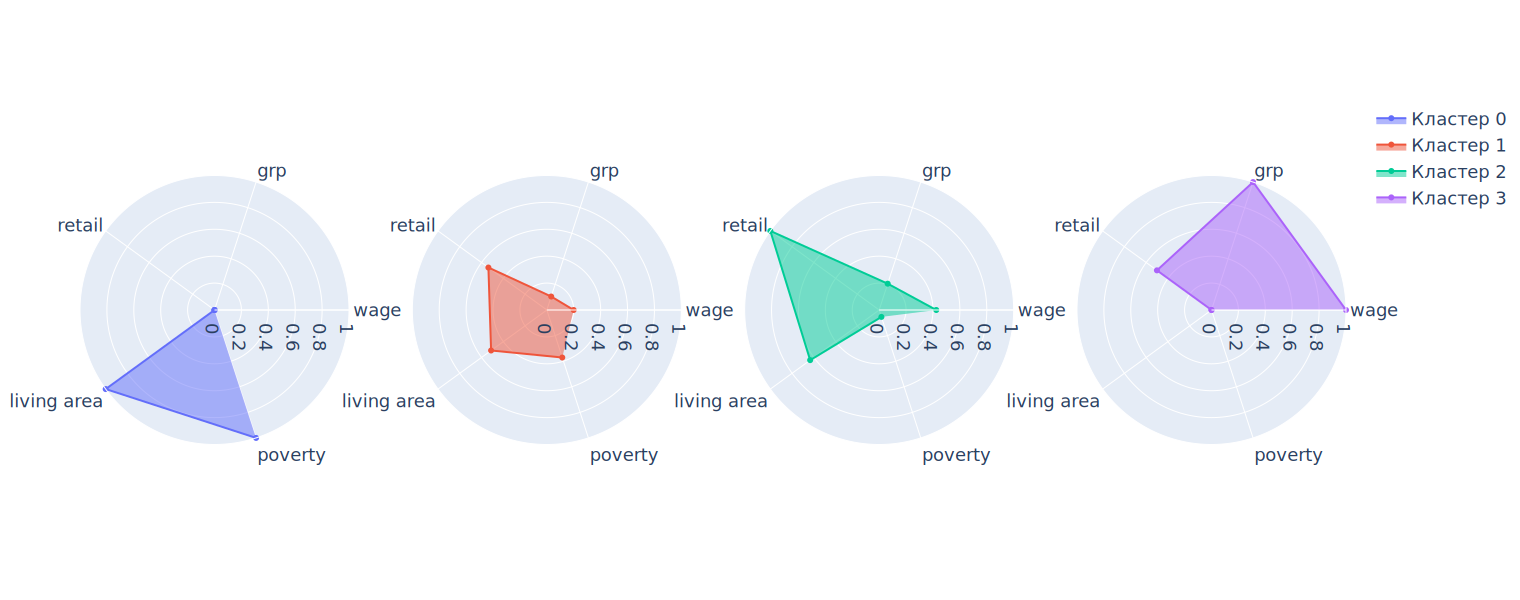

In [61]:
df['formal wage norm'] = df['formal wage'] / df['living wage']
df['retail norm'] = df['retail'] / df['living wage']

cols = ['formal wage norm', 'grp', 'retail norm', 'living area', 'poverty']
medians = df.groupby('cluster')[cols].median()

medians.rename(
    {'formal wage norm': 'wage', 'retail norm': 'retail'}, 
    axis=1, inplace=True)
features = medians.columns
scaler = MinMaxScaler()
medians_scaled = pd.DataFrame(scaler.fit_transform(medians), 
                            columns=features)

fig = make_subplots(rows=1, cols=4, specs=[[{'type': 'polar'}]*4]*1)

fig.add_trace(go.Scatterpolar(  
    name = 'Кластер 0',
    r = medians_scaled.loc[0].values,
    theta = features,
    fill='toself',
    ), 1, 1)

fig.add_trace(go.Scatterpolar(
    name = 'Кластер 1',
    r = medians_scaled.loc[1].values,
    theta = features,
    fill='toself'
    ), 1, 2)

fig.add_trace(go.Scatterpolar(
    name = 'Кластер 2',
    r = medians_scaled.loc[2].values,
    theta = features,
    fill='toself'
    ), 1, 3)

fig.add_trace(go.Scatterpolar(
    name = "Кластер 3",
    r = medians_scaled.loc[3].values,
    theta = features,
    fill='toself'
    ), 1, 4)

fig.update_polars(radialaxis=dict(range=[0, 1]))
fig.update_layout(
    font_size=18,
    showlegend=True, # отображение легенды
    autosize=False, # устаналиваем свои размеры графика
    width=1520, 
    height=600) 
fig.show('svg')
fig.write_image('data/social_russia_data/figs_3d/Clasters.png')

In [62]:
display('Медианные значения в числовом выражении:', medians)

'Медианные значения в числовом выражении:'

,wage,grp,retail,living area,poverty
cluster,,,,,
0,2.802268,210674.10,7.879971,18.9,23.60
1,3.222692,403949.10,15.601578,16.9,13.70
2,3.697432,588270.00,22.259528,17.4,8.70
3,4.910683,2047106.75,15.089111,14.8,7.85


***Кластер 0***  - кластер беднейших регионов. Наиболее низкие заработки, валовый региональный продукт, объемы розничной торговли (половина от среднестатистической) и самый высокий процент населения за чертой бедности (почти вдвое больше среднестатистического). Под среднестатистическими данными здесь понимаем медианные значения для наиболее многочисленного кластера 1. Интересно, что одновременно этот кластер демонстрирует самую высокую среднюю жилплощадь на человека (как будет показано ниже, различия между кластерами по размеру жилой площади имеют слабую статистическую значимость: $5\% <$ p-value $< 10\%$). 

In [63]:
K0=df[df['cluster'] == 0].index.to_list()
print(f'Список регионов Кластера 0: {str(K0)[1:-1]}') 

Список регионов Кластера 0: 'Еврейская автономная область', 'Кабардино-Балкарская Республика', 'Карачаево-Черкесская Республика', 'Республика Ингушетия', 'Республика Калмыкия', 'Республика Тыва', 'Чеченская Республика'


***Кластер 1*** - наиболее наполненный кластер "среднестатистических регионов". Медианные показатели (в расчете на одного человека): зарплата 2.3 прожиточных минимума в месяц, валовый региональный продукт около 400 т.р., годовой объем розничной торговли 15.6 прожиточных минимумов, жилплощадь около 17 кв.м, 13.7% населения за чертой бедности.

In [64]:
K1=df[df['cluster'] == 1].index.to_list()
print(f'Список регионов Кластера 1: {str(K1)[1:-1]}') 

Список регионов Кластера 1: 'Алтайский край', 'Амурская область', 'Архангельская область без Ненецкого АО', 'Астраханская область', 'Брянская область', 'Владимирская область', 'Волгоградская область', 'Вологодская область', 'Забайкальский край', 'Ивановская область', 'Иркутская область', 'Калининградская область', 'Калужская область', 'Камчатский край', 'Кемеровская область', 'Кировская область', 'Костромская область', 'Красноярский край', 'Курганская область', 'Курская область', 'Мурманская область', 'Новгородская область', 'Новосибирская область', 'Омская область', 'Оренбургская область', 'Орловская область', 'Пензенская область', 'Пермский край', 'Приморский край', 'Псковская область', 'Республика Адыгея', 'Республика Алтай', 'Республика Бурятия', 'Республика Дагестан', 'Республика Карелия', 'Республика Коми', 'Республика Крым', 'Республика Марий Эл', 'Республика Мордовия', 'Республика Саха (Якутия)', 'Республика Северная Осетия-Алания', 'Республика Хакасия', 'Ростовская область', '

***Кластер 2*** - "зона комфорта". Эти регионы, по-видимому, можно считать наиболее комфортными для жизни в РФ. Заработки выше среднего (хотя и значительно ниже ниже, чем у "бизнес-регионов" кластера 3), относительно высокий валовый региональный продукт (соответственно более высокое наполнение региональных бюджетов), самый большой объем розничной торговли, низкий процент бедного населения (8.7%, лишь чуть выше, чем у лидеров рейтинга). 

In [65]:
K2=df[df['cluster'] == 2].index.to_list()
print(f'Список регионов Кластера 2: {str(K2)[1:-1]}') 

Список регионов Кластера 2: 'Белгородская область', 'Воронежская область', 'Краснодарский край', 'Ленинградская область', 'Липецкая область', 'Московская область', 'Нижегородская область', 'Республика Башкортостан', 'Республика Татарстан', 'Свердловская область', 'Тюменская область без округов'


***Кластер 3*** - "бизнес-регионы". Москва, Санкт-Петербург, Сахалин, а также "северные" регионы с предприятиями ресурсодобывающего сектора. Наиболее высокие зарплаты, валовый региональный продукт в 5 раз выше среднестатистического, самый низкий уровень бедности. Одновременно - средние показатели розничной торговли, и самая низкая обеспеченность жилплощадью.

In [66]:
K3=df[df['cluster'] == 3].index.to_list()
print(f'Список регионов Кластера 3: {str(K3)[1:-1]}') 

Список регионов Кластера 3: 'Магаданская область', 'Москва', 'Ненецкий автономный округ', 'Санкт-Петербург', 'Сахалинская область', 'Ханты-Мансийский автономный округ - Югра', 'Чукотский автономный округ', 'Ямало-Ненецкий автономный округ'


Рассмотрим статистическую значимость наблюдаемых различий. Как было показано в Части 2 настоящего проекта, распределения признаков не являются нормальными, а количество сравниваемых групп больше двух. В этом случае можно применить непараметрический критерий Крускала-Уоллиса. 

In [67]:
def kruskal_pvalue(df, col):
    "p-value для заданной колонки (значимость различий по 4-м кластерам)"
    v0 = df[df['cluster'] == 0][col]
    v1 = df[df['cluster'] == 1][col]
    v2 = df[df['cluster'] == 2][col]
    v3 = df[df['cluster'] == 3][col]
    _, p = kruskal(v0, v1, v2, v3)
    return p


cols = ['formal wage norm', 'grp', 'retail norm', 'living area', 'poverty']
for col in cols:
    print(f'{col}:   p-value = {kruskal_pvalue(df, col):.3f}')

formal wage norm:   p-value = 0.000
grp:   p-value = 0.000
retail norm:   p-value = 0.000
living area:   p-value = 0.084
poverty:   p-value = 0.000


Различия по всем признакам, кроме одного, значимы на уровне лучше 1%, у различий по размеру жилой площади значимость слабая: на уровне 10%. 

Проверим также справедливость выделения "зоны комфорта" в отдельный кластер 2 путем сравнения этой группы с кластером 1 среднестатистических регионов по критерию Манна-Уитни. 

In [68]:
def mannwhitney_pvalue(df, col, cl_couple):
    "p-value для пары кластеров (cl_couple) по заданной колонке"
    v0 = df[df['cluster'] == cl_couple[0]][col]
    v1 = df[df['cluster'] == cl_couple[1]][col]
    _, p = mannwhitneyu(v0, v1)
    return p


cols = ['formal wage norm', 'grp', 'retail norm', 'living area', 'poverty']
for col in cols:
    print(f'{col}:   p-value = {mannwhitney_pvalue(df, col, (1, 2)):.3f}')

formal wage norm:   p-value = 0.001
grp:   p-value = 0.003
retail norm:   p-value = 0.000
living area:   p-value = 0.686
poverty:   p-value = 0.000


Как видим, эти две группы действительно значимо отличаются по всем признакам за исключением размера жилой площади.

### 3.2 Группы населения, сталкивающиеся с бедностью

В нашем распоряжении есть статистика о распределении малоимущего населения по социально-демографическим группам.

In [69]:
D3=df[df['cluster'] == 3]
D3

,per capita,formal wage,child mortality,disabled 18_60,alco (2018),drug (2018),grp,living area,bad conditions,no funds,...,grievous harm,children %,orphanage,adopted %,pension,retired %,living wage,cluster,formal wage norm,retail norm
region,,,,,,,,,,,,,,,,,,,,,
Магаданская область,70864.0,102843.0,0.304414,3.159090,127.0,6.2,2035007.0,13.8,0.2,0.0000,...,53,20.999793,214,53.0,26112.75,21.2,22027.0,3,4.668952,11.159804
Москва,77283.0,100070.0,0.364302,3.880842,23.1,8.7,1567644.8,13.8,0.5,4.0960,...,980,17.088196,1324,66.0,19115.10,26.9,20260.0,3,4.939289,20.171471
Ненецкий автономный округ,84147.0,92237.0,0.673401,4.878965,181.8,2.3,5206287.1,20.9,5.9,0.0000,...,14,27.165560,20,65.0,27264.59,18.5,22971.0,3,4.015367,9.847460
Санкт-Петербург,49207.0,68667.0,0.344523,3.935286,14.7,9.4,971158.0,15.7,0.1,0.4815,...,528,17.544049,1265,53.0,19203.41,26.4,13074.0,3,5.252180,21.683800
Сахалинская область,60770.0,92518.0,0.447147,3.563045,106.1,18.4,2059206.5,17.2,0.6,0.0000,...,158,21.863281,315,57.0,23008.29,22.7,17178.0,3,5.385842,19.722145
Ханты-Мансийский автономный округ - Югра,54443.0,79822.0,0.363989,2.788719,33.7,6.2,1994630.3,13.9,2.8,5.8128,...,435,25.469524,25,89.0,25733.60,15.9,17140.0,3,4.657060,15.059335
Чукотский автономный округ,89541.0,120641.0,1.489758,3.515586,208.7,0.0,2404271.2,14.1,1.9,0.0000,...,20,25.099427,60,69.0,30144.56,14.5,24711.0,3,4.882077,8.785116
Ямало-Ненецкий автономный округ,89928.0,111216.0,0.352510,2.251771,94.7,18.9,5072483.6,15.5,1.7,5.0091,...,128,26.411164,68,83.0,25796.80,11.8,17403.0,3,6.390622,15.118888


the poor: children      38.720000
the poor: employable    55.656471
the poor: retired        5.631765
dtype: float64


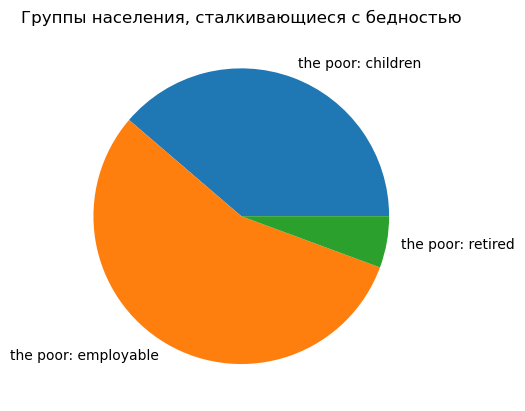

In [70]:
cols =[
    'the poor: children',
    'the poor: employable', 
    'the poor: retired']
print(df[cols].mean())

fig, ax = plt.subplots()
ax.pie(df[cols].mean(), labels=cols)
ax.set_title("Группы населения, сталкивающиеся c бедностью")
# show plot
plt.show()
fig.savefig('data/social_russia_data/figs_3d/poor_people.png')

График по регионам

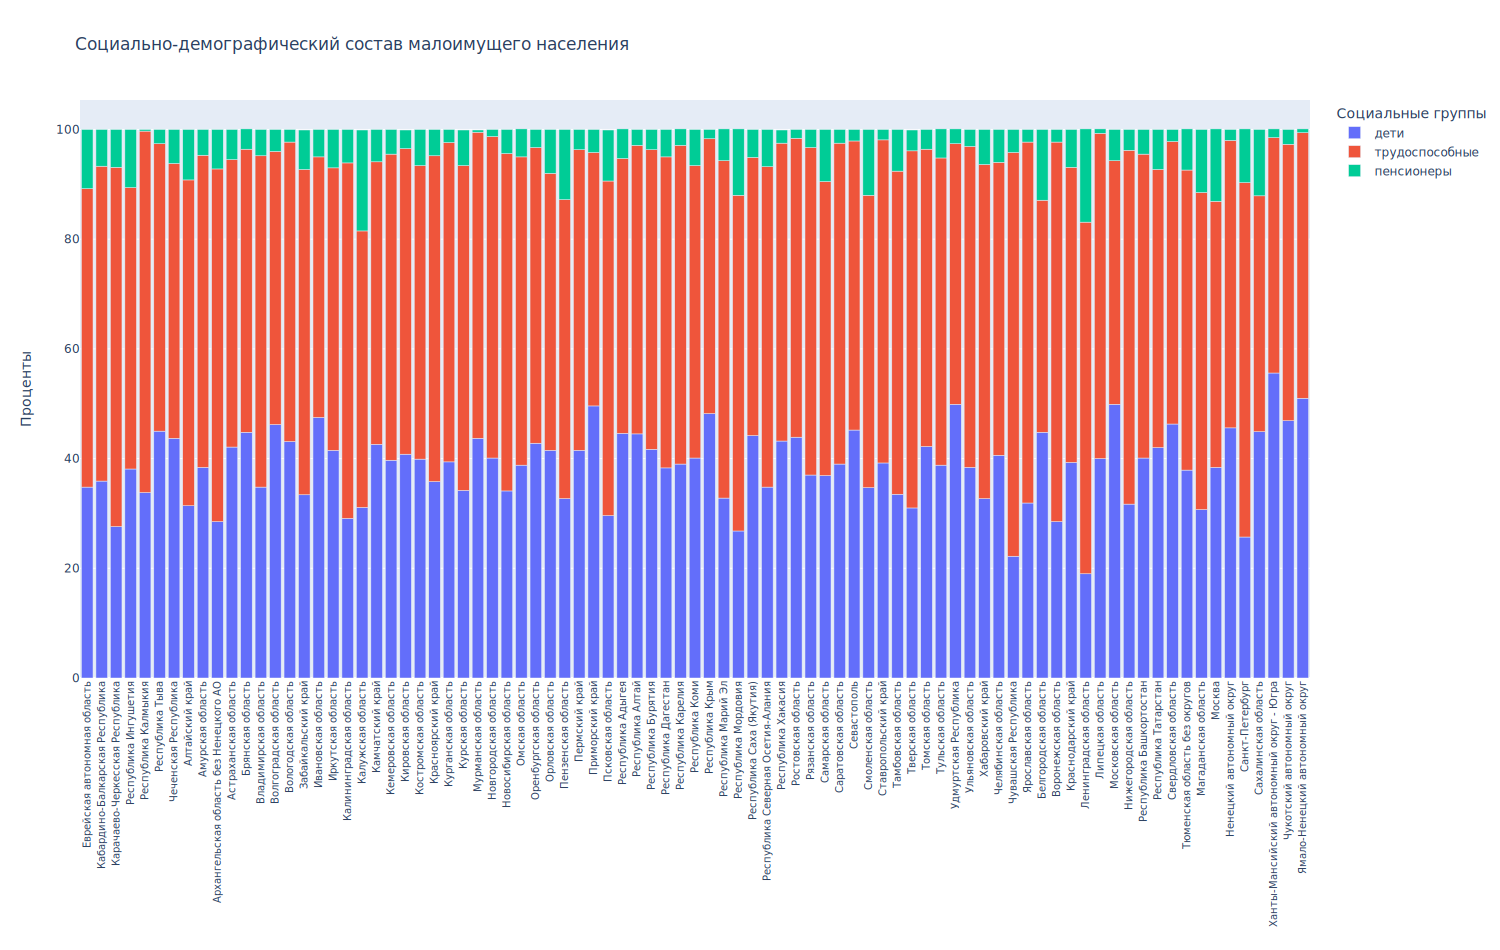

In [71]:
plot_df = df.sort_values(by=['cluster', 'region'])[cols].rename({
    'the poor: children': 'дети',
    'the poor: employable': 'трудоспособные',
    'the poor: retired': 'пенсионеры' 
}, axis=1)
fig = px.bar(plot_df, width=1500, height=950,
    title='Социально-демографический состав малоимущего населения')
fig.layout.xaxis.tickfont.size = 10
fig.update_xaxes(tickangle=270, title=None)
fig.update_yaxes(title='Проценты')
fig.layout.legend.title = 'Социальные группы'
fig.show('svg')
fig.write_image('data/social_russia_data/figs_3d/People.png')

***Вывод:***  Некоторые вариации присутствуют, однако существенных отличий между регионами, а также между кластерамии не наблюдается. Основной состав малоимущего населения - это люди трудоспособного возраста (56%) и дети (39%). На пенсионеров приходится около 5%. Однако эти показатели ничего не говорят о проценте малоимущих внутри каждой из социально-демографических групп.Вывод

Рассчитаем процент малоимущих в социально-демографических группах

In [72]:
socgroups = df[[
    'population', 'poverty', 'the poor: children',
    'the poor: retired', 'the poor: employable', 
    'children %', 'retired %']].copy()

# Процент трудоспособных
socgroups['employable %'] = (100 - socgroups['children %'] - socgroups['retired %']) 

# Количество малоимущих
socgroups['the poor'] = (socgroups['population'] * socgroups['poverty'] / 100).round(0).astype(int)  

# Количество людей в социально-демографических группах
socgroups['children'] = ((socgroups['population'] * socgroups['children %'] / 100).round(0).astype(int))  
socgroups['employable'] = ((socgroups['population'] * socgroups['employable %'] / 100).round(0).astype(int))  
socgroups['retired'] = ((socgroups['population'] * socgroups['retired %'] / 100).round(0).astype(int))  

# Количество малоимущих в социально-демографических группах
socgroups['poor children'] = ((socgroups['the poor'] * socgroups['the poor: children'] / 100).round(0).astype(int))
socgroups['poor employable'] = ((socgroups['the poor'] * socgroups['the poor: employable'] / 100).round(0).astype(int))   
socgroups['poor retired'] = ((socgroups['the poor'] * socgroups['the poor: retired'] / 100).round(0).astype(int))    

# Процент малоимущих в социально-демографических группах
socgroups['poor children %'] = ((socgroups['poor children'] / socgroups['children'] * 100))  
socgroups['poor employable %'] = ((socgroups['poor employable'] / socgroups['employable'] * 100))  
socgroups['poor retired %'] = ((socgroups['poor retired'] / socgroups['retired'] * 100))  

# Среднее по РФ
cols =[
    'poor children %',
    'poor employable %', 
    'poor retired %']
poor_percent = socgroups[cols].mean()
poor_percent

poor children %      24.411145
poor employable %    14.405406
poor retired %        3.435074
dtype: float64

В среднем по стране за чертой бедности находятся 24% детей, 14% трудоспособного населения и около 3% пенсионеров. Данная статистика свидетельствует о том, что малоимущими чаще оказываются семьи с детьми - видим большой процент малоимущих среди детей при гораздо меньшем проценте малоимущих среди трудоспособного населения. При этом трудоспособные составляют 56% малоимущего населения - больше чем дети (39%), т.е. многие из малоимущих оказываются в бедственном положении уже при рождении первого ребенка. 

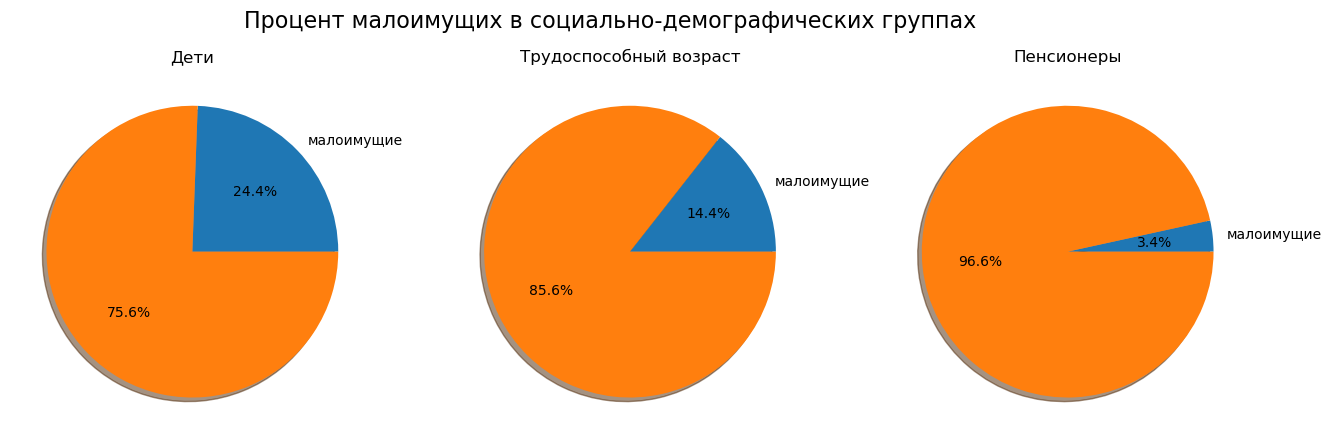

In [73]:
labels = ['малоимущие', '']
fig, ax = plt.subplots(1, 3, figsize=(16,5))
ax[0].pie([poor_percent[0], 100-poor_percent[0]], labels=labels, autopct='%1.1f%%', shadow=True)
ax[1].pie([poor_percent[1], 100-poor_percent[1]], labels=labels, autopct='%1.1f%%', shadow=True)
ax[2].pie([poor_percent[2], 100-poor_percent[2]], labels=labels, autopct='%1.1f%%', shadow=True);
ax[0].set_title('Дети')
ax[1].set_title('Трудоспособный возраст')
ax[2].set_title('Пенсионеры')
fig.suptitle('Процент малоимущих в социально-демографических группах', fontsize=16)
fig.set_facecolor('white')

Посмотрим на аналогичные показатели по кластерам. Помимо закономерного падения процента малоимущих от кластера 0 к кластеру 3 (уровень бедности закладывался как признак кластеризации), можно отметить также значительно больший процент малоимущих пенсионеров в беднейших регионах: 10%, в то время как во всех остальных кластерах он не превышает 3%.

In [74]:
socgroups['cluster'] = df['cluster']
cluster_socgroups = (socgroups.groupby('cluster')[['children', 'employable', 'retired', 'poor children', 'poor employable', 'poor retired']].sum())
cluster_socgroups['poor children %'] = (cluster_socgroups['poor children'] / cluster_socgroups['children'] * 100)  
cluster_socgroups['poor employable %'] = (cluster_socgroups['poor employable'] / cluster_socgroups['employable'] * 100)  
cluster_socgroups['poor retired %'] = (cluster_socgroups['poor retired'] / cluster_socgroups['retired'] * 100) 
cluster_socgroups

,children,employable,retired,poor children,poor employable,poor retired,poor children %,poor employable %,poor retired %
cluster,,,,,,,,,
0,1242922,2205422,628144,375537,535796,63277,30.214044,24.294489,10.073646
1,17662844,45464356,21279828,4600087,6662309,600322,26.043864,14.653917,2.821085
2,7620001,20234876,9392129,1318837,1793486,193521,17.307570,8.863341,2.060459
3,3844605,11851455,5322008,489898,675086,140199,12.742479,5.696229,2.634325


### 3.3 Взаимосвязь численности социально-демографических групп с уровнем бедности

In [75]:
cluster_socgroups['population'] = (df.groupby('cluster')['population'].sum().astype(int))
cluster_socgroups['children %'] = (cluster_socgroups['children'] /  cluster_socgroups['population'] * 100)
cluster_socgroups['employable %'] = (cluster_socgroups['employable'] /  cluster_socgroups['population'] * 100)
cluster_socgroups['retired %'] = (cluster_socgroups['retired'] /  cluster_socgroups['population'] * 100)
display(cluster_socgroups)

,children,employable,retired,poor children,poor employable,poor retired,poor children %,poor employable %,poor retired %,population,children %,employable %,retired %
cluster,,,,,,,,,,,,,
0,1242922,2205422,628144,375537,535796,63277,30.214044,24.294489,10.073646,4076488,30.490020,54.101030,15.408950
1,17662844,45464356,21279828,4600087,6662309,600322,26.043864,14.653917,2.821085,84407028,20.925798,53.863235,25.210967
2,7620001,20234876,9392129,1318837,1793486,193521,17.307570,8.863341,2.060459,37247006,20.458023,54.326181,25.215796
3,3844605,11851455,5322008,489898,675086,140199,12.742479,5.696229,2.634325,21018068,18.291905,56.386986,25.321109


Нулевая гипотеза: процент детей в разных кластерах одинаков
chi-square test p-value = 0.0


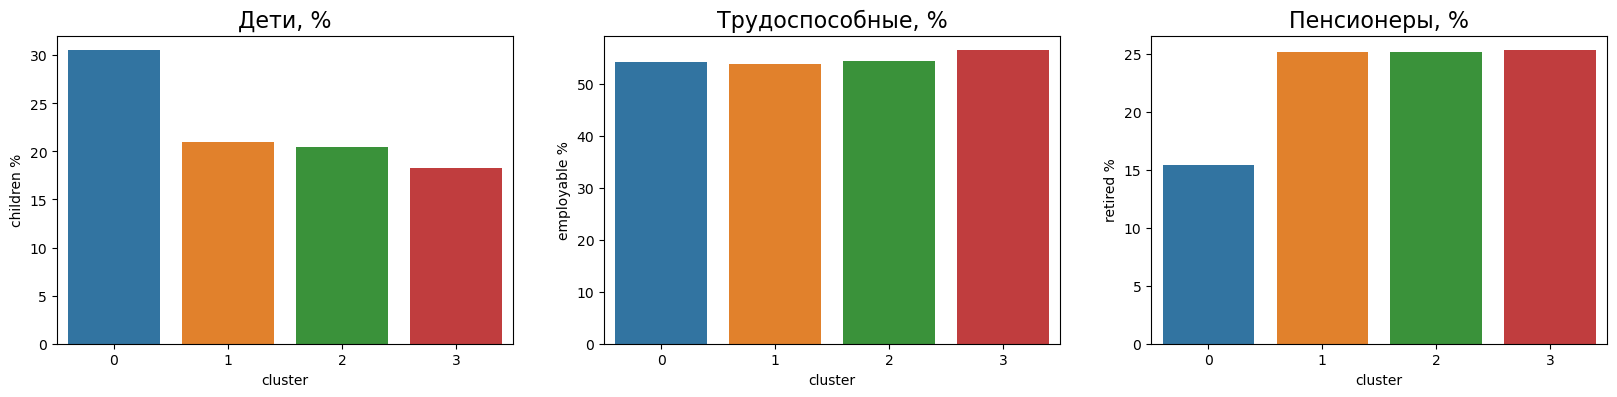

In [76]:
fig, ax  = plt.subplots(1, 3, figsize=(20, 4))
ax[0].bar(cluster_socgroups.index, cluster_socgroups['children %'])
sns.barplot(data=cluster_socgroups, x=cluster_socgroups.index, y='children %', ax=ax[0])
sns.barplot(data=cluster_socgroups, x=cluster_socgroups.index, y='employable %', ax=ax[1])
sns.barplot(data=cluster_socgroups, x=cluster_socgroups.index, y='retired %', ax=ax[2])
ax[0].set_title('Дети, %', fontsize=16)
ax[1].set_title('Трудоспособные, %', fontsize=16)
ax[2].set_title('Пенсионеры, %', fontsize=16)

stat, p, tab = proportions_chisquare(cluster_socgroups['children'], cluster_socgroups['population'])
print('Нулевая гипотеза: процент детей в разных кластерах одинаков')
print(f'chi-square test p-value = {p}');

Из обработанных данных мы видим, что существенных отличий в процентах трудоспособного населения не наблюдается: величины колеблются в пределах 54% - 56%, такие различия в рабочей силе вряд ли оказывают какое-либо влияние на экономику регионов, особенно в виду кратной разницы в уровне доходов. Одновременно можно отметить, что в беднейших регионах наблюдается существенно больший процент детей и меньший процент пенсионеров (тоже на 10%). Процент детей в целом падает с ростом финансового благополучия (от кластера 0 к кластеру 3). Различия статистически значимы: 
* тест на пропорции дает p-value = 0. Это в целом соответствует полученному ранее выводу о том, что семьи с детьми являются наиболее уязвимым слоем населения с финансовой точки зрения. Можно предположить, что в более бедных регионах выше рождаемость, что оказывает дополнительное негативное влияние на показатели дохода на душу населения. 

Посмотрим на показатели рождаемости.

Нулевая гипотеза: рождаемость не зависит от кластера
Kruskal-Wallis p-value = 0.000


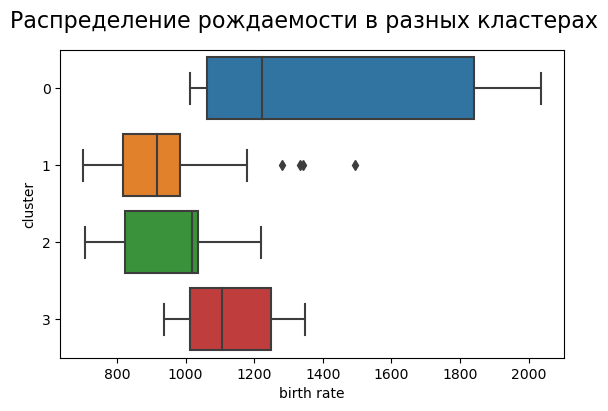

In [77]:
fig = plt.figure(figsize=(6.5, 4))
sns.boxplot(data=df, x='birth rate', y='cluster', orient='h')
fig.suptitle('Распределение рождаемости в разных кластерах',fontsize=16);

print('Нулевая гипотеза: рождаемость не зависит от кластера')
print(f"Kruskal-Wallis p-value = {kruskal_pvalue(df, 'birth rate'):.3f}")

Видим, что действительно кластер беднейших регионов показывает максимальную рождаемость (в расчете на 100 тыс. населения), однако в трех других кластерах тенденция противоположная: рождаемость немного растет с ростом благосостояния. Можно сделать вывод, что в беднейших регионах присутствует особая ситуация: высокая рождаемость, необеспеченная доходами родителей.

### 3.4 Другие различия между кластерами
Рассмотрим другие отличия между кластерами. Для этого выберем в DataFrame признаки, которые еще не рассматривались, из них выберем только те, которые показывают статистически значимые различия между кластерами на уровне 5% по критерию Краскела-Уоллиса. Отметим, что даже статистически значимые различия не являются доказательством прямой взаимосвязи между уровнем финансового благополучия (кластером) и рассматриваемой характеристикой, однако такой анализ позволяет выдвинуть определенные гипотезы. Дополнительно нормируем некоторые показатели на 100 тыс. населения для усреднения численности населения в регионах.

In [78]:
# 1 пропущенное значение заменяем на медиану
df['adopted %'] = df['adopted %'].fillna(df['adopted %'].median()) 
# Нормируем пенсию на размер потребительской корзины
df['pension norm'] = df['pension'] / df['living wage']
# Пересчитываем кол-во преступлений на 100 тыс. населения
df['registered crimes'] = (
    df['registered crimes'] / df['population'] * 100_000)
df['felonies'] = (
    df['felonies'] / df['population'] * 100_000)
df['misdemeanors'] = (
    df['misdemeanors'] / df['population'] * 100_000)
df['killed'] = (
    df['killed'] / df['population'] * 100_000)
df['grievous harm'] = (
    df['grievous harm'] / df['population'] * 100_000)
# Кол-во детей в детских домах на 100 тыс. населения
df['orphanage'] = (
    df['orphanage'] / df['population'] * 100_000)

cols = [
    'child mortality', 'disabled 18_60', 'alco (2018)', 'drug (2018)', 
    'bad conditions', 'no funds', 'morbidity (2016)', 
    'congenital malformation (2016)', 'psychosis (2016)', 
    'teenage pregnancy (2016)', 'population', 'subsidies', 'welfare', 
    'registered crimes', 'felonies', 'misdemeanors', 'killed', 
    'grievous harm', 'orphanage', 'adopted %', 'pension', 
    'pension norm', 'living wage'
]

cols_s = cols.copy()
for col in cols:
    p = kruskal_pvalue(df, col)
    print(f'{col}:   p-value = {p:.3f}')
    if p > 0.05: 
        cols_s.remove(col)

child mortality:   p-value = 0.075
disabled 18_60:   p-value = 0.000
alco (2018):   p-value = 0.068
drug (2018):   p-value = 0.834
bad conditions:   p-value = 0.445
no funds:   p-value = 0.422
morbidity (2016):   p-value = 0.000
congenital malformation (2016):   p-value = 0.006
psychosis (2016):   p-value = 0.015
teenage pregnancy (2016):   p-value = 0.275
population:   p-value = 0.000
subsidies:   p-value = 0.000
welfare:   p-value = 0.000
registered crimes:   p-value = 0.131
felonies:   p-value = 0.413
misdemeanors:   p-value = 0.085
killed:   p-value = 0.625
grievous harm:   p-value = 0.457
orphanage:   p-value = 0.034
adopted %:   p-value = 0.008
pension:   p-value = 0.000
pension norm:   p-value = 0.005
living wage:   p-value = 0.000


Кластеры НЕ отличаются по следующим характеристикам (показатели нормированы на 100 тыс. населения либо приведены в процентах): 

уровень детской смертности,

уровень алкоголизма и наркомании,

уровень подростковой беременности,

процент плохих жилищных условий,

уровень преступности, в т.ч. по преступлениям различной тяжести.

Построим графики распределений для значимо отличающихся характеристик.

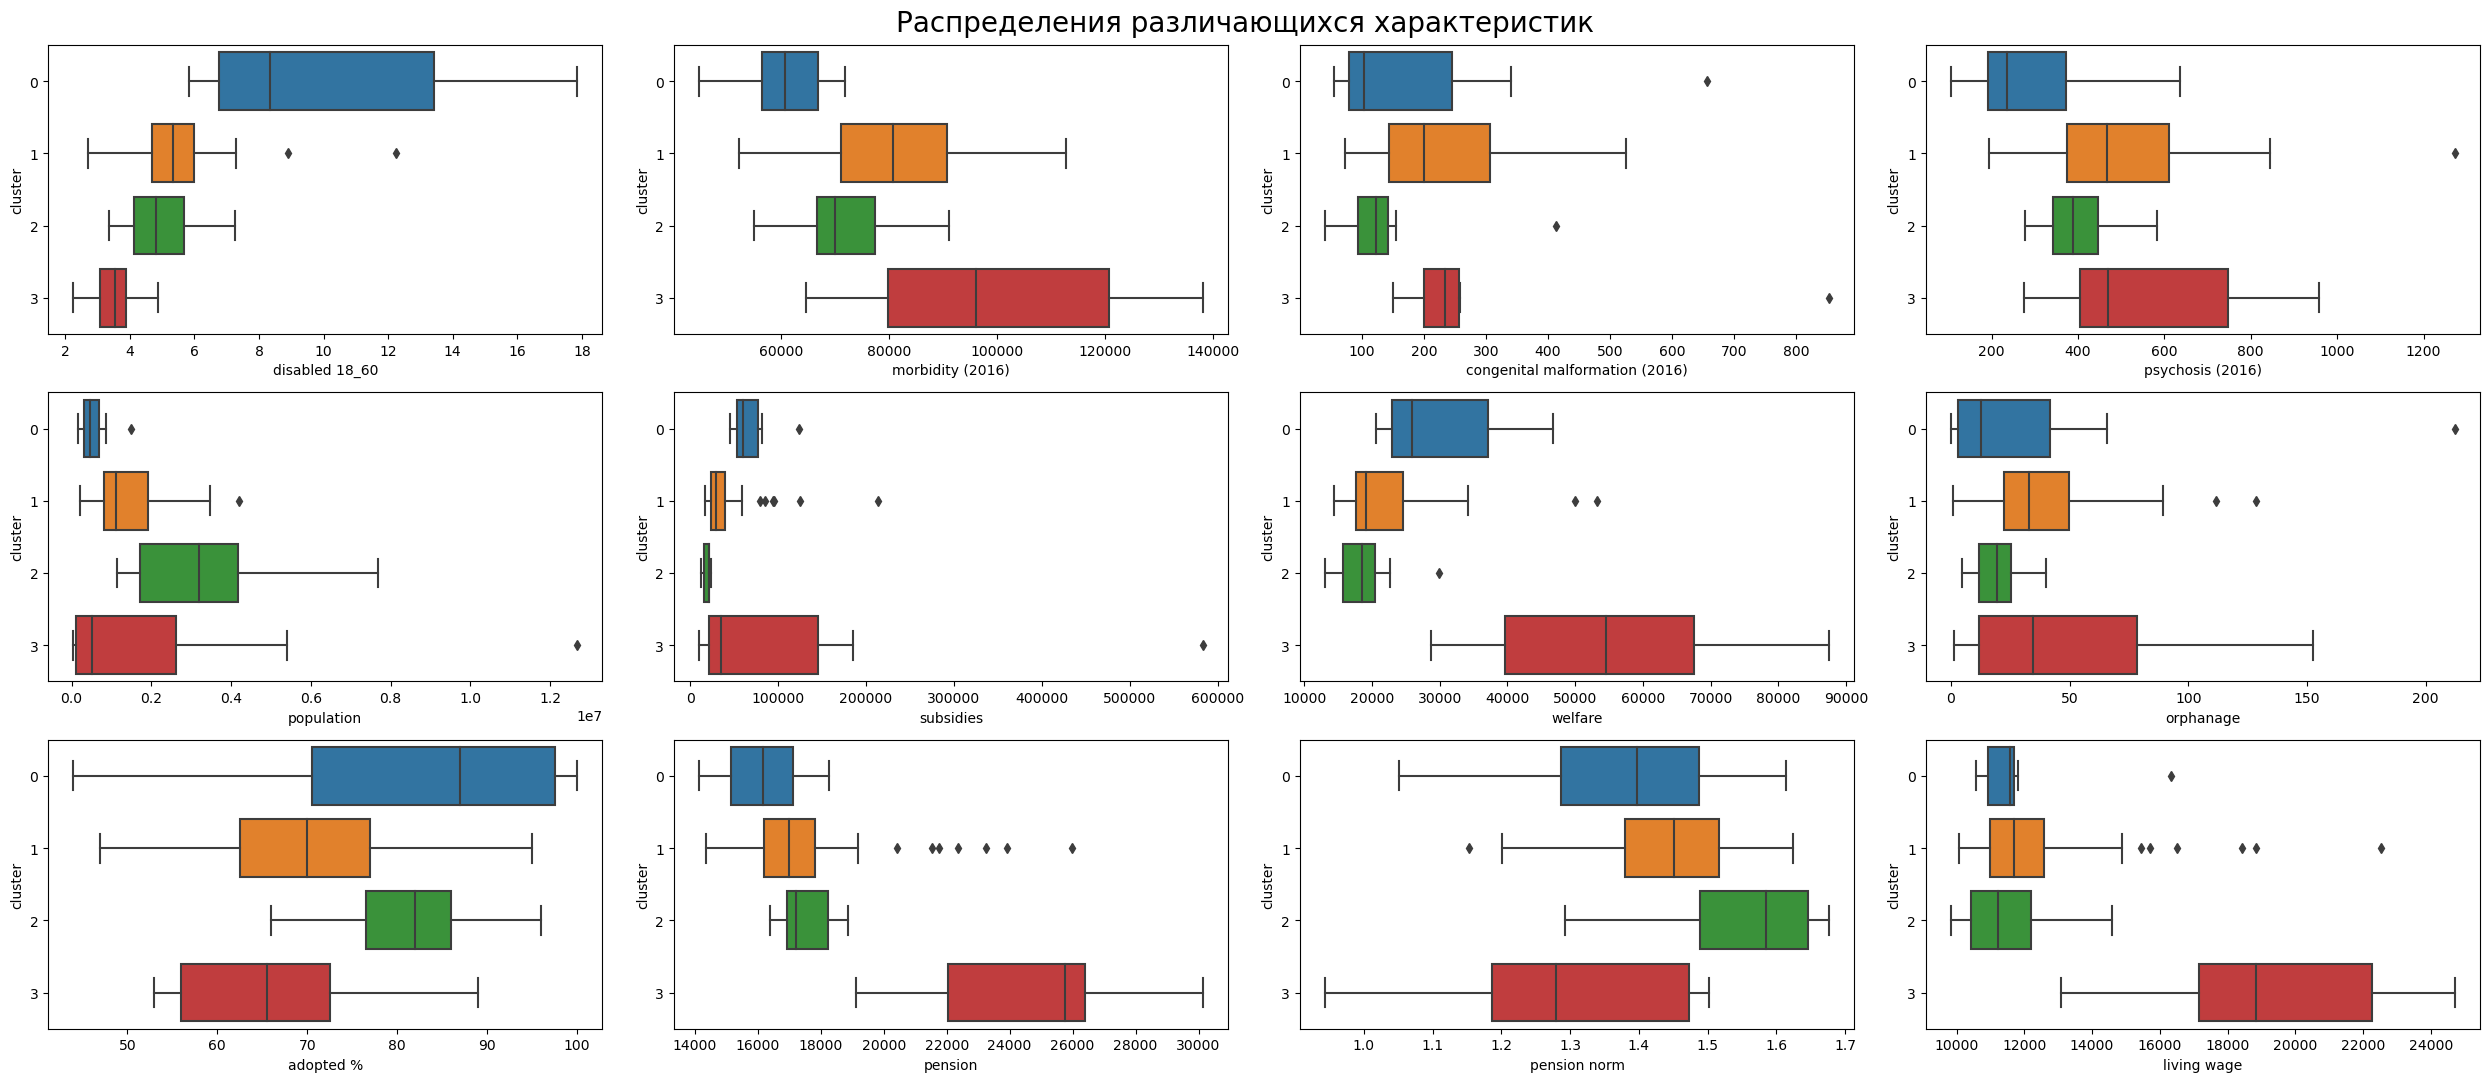

In [79]:
fig, ax = plt.subplots(3, 4, figsize=(25, 11))
i = 0
for row in range(3):
    sns.boxplot(data=df, x=cols_s[i], y='cluster', orient='h', ax=ax[row,0])
    sns.boxplot(data=df, x=cols_s[i+1], y='cluster', orient='h', ax=ax[row,1])
    sns.boxplot(data=df, x=cols_s[i+2], y='cluster', orient='h', ax=ax[row,2])
    sns.boxplot(data=df, x=cols_s[i+3], y='cluster', orient='h', ax=ax[row,3])
    i += 4
fig.suptitle('Распределения различающихся характеристик', 
            fontsize=20)
plt.tight_layout()

### Описание
***Кластер 0*** - бедные регионы (7 шт.)

***Кластер 1*** - средние регионы (59 шт.)

***Кластер 2*** - регионы "комфорт" (11 шт.)

***Кластре 3*** - бизнес-регионы (8 шт.)


* В бедных регионах существенно выше инвалидность среди граждан трудоспособного возраста (6% - 18%); бизнес-регионы, наоборот, демонстрируют самый низкий процент (2% - 5%).
* Общая заболеваемость населения (morbidity) наиболее высока в бизнес-регионах, наименьшие показатели заболеваемости - в бедных регионах. Статистика может быть связана не только с медицинскими показателями, но и с другими факторами, например с дисциплиной оформления официальных больничных или большей самозанятостью населения в бедных регионах.
* Врожденные пороки развития (congenital malformation): есть различия между кластерами, однако определенные выводы сделать сложно.
* Психические расстройства на 100 тыс. населения (psychosis): бедные регионы демонстрируют самые низкие значения.
* Население регионов (population). Наибольшие значения, в среднем, показывают регионы "комфорт" (1-8 млн на федеральный субъект), хотя абсолютныq рекордсмен, разумеется, Москва (12.7 млн жителей), принадлежащая к кластеру бизнес-регионов. В бедных регионах население не превышает 2 млн на субъект (как правило, меньше 1 млн).
* Дотации (subsidies), выделенные регионам из федерального бюджета, в расчете на одного жителя. Наибольшие вариации - в бизнес-регионах (от 10 т.р., Санкт-Петербург, до полумиллиона, Чукотский АО). Высокие суммы наиболее вероятно связаны с выполнением проектов федерального уровня. В остальных кластерах в среднем наиболее дотационными являются бедные регионы, и наиболее самостоятельными - регионы "комфорт".
* Расходы региональных бюджетов на социальную политику (welfare). Абсолютные лидеры - бизнес регионы (30 - 90 т.р. на человека). Достаточно высоки расходы в бедных регионах (20 - 50 т.р.). Меньше всего тратят на социальную политику регионы "комфорт" (10 - 30 т.р.).
* Наименьшее количество детей в детских домах в расчете на 100 тыс. населения (orphanage) - в регионах "комфорт", хотя некоторые регионы во всех кластерах демонстрируют нулевые или близкие к нулевым цифры. Больше всего "населенность" детских домов в бизнес-регионах (за исключением абсолютного "рекордсмена" из кластера бедных регионов - Еврейской АО). Процент усыновленных/удочеренных детей (adopted) отличается по кластерам, однако определенные выводы сделать трудно - разброс достаточно велик, в целом опекунство оформляется более чем для 50% сирот почти во всех регионах.

* Интересную картину мы наблюдаем в пенсионном обеспечении: с одной стороны, бизнес-регионы резко выделяются по абсолютному размеру пенсии (pension, 20 - 30 т.р.), однако в перерасчете на прожиточный минимум (pension norm) проигрывают не только регионам "комфорт", но и некоторым федеральным субъектам из кластера бедных регионов. Так, нормированная московская пенсия составляет 0.9 прожиточных минимумов, в то время как в Республике Ингушетия она равна более полутора прожиточным минимумам. В целом размер пенсий невелик - до 1.7 прожиточных минимума у лидеров рейтинга (регионы "комфорт").

* Прожиточный минимум в регионах (living wage). Абсолютные лидеры - бизнес регионы, стоимость потребительской корзины (13 - 25 т.р.). Остальные три кластера в целом мало отличаются друг от друга (хотя в кластере средних регионов достаточно много выбросов в сторону высоких цен, и есть один такой выброс в кластере бедных регионов - Еврейская АО). При этом лидер рейтинга по низким ценам (Воронежская обл.) находится среди регионов "комфорт".

In [80]:
col = 'living wage'  # колонка
cluster = 3          # кластер

mask = df['cluster'] == cluster
df[mask][col].sort_values(ascending=False)

region
Чукотский автономный округ                  24711.0
Ненецкий автономный округ                   22971.0
Магаданская область                         22027.0
Москва                                      20260.0
Ямало-Ненецкий автономный округ             17403.0
Сахалинская область                         17178.0
Ханты-Мансийский автономный округ - Югра    17140.0
Санкт-Петербург                             13074.0
Name: living wage, dtype: float64

In [81]:
col = 'living wage'  # колонка
cluster = 0          # кластер

mask = df['cluster'] == cluster
df[mask][col].sort_values(ascending=False)

region
Еврейская автономная область       16336.0
Кабардино-Балкарская Республика    11819.0
Республика Тыва                    11594.0
Чеченская Республика               11572.0
Карачаево-Черкесская Республика    10926.0
Республика Калмыкия                10914.0
Республика Ингушетия               10580.0
Name: living wage, dtype: float64

### Вывод
Дано описание характерных особенностей полученных кластеров:

* бедные регионы;
* среднестатистические регионы;
* регионы "комфорт"
* бизнес-регионы.

Проведен анализ социально-демографических групп населения, показывающий, что наиболее уязвимой группой населения по финасовым показателям являются семьи с детьми. При этом в кластере наиболее бедных регионов наблюдается аномально высокая рождаемость, необеспеченная доходами родителей, а доля детей среди всего населения на 10% больше, чем в остальных регионах. В остальных группах рождаемость слабо растет с ростом финансового благополучия. При этом процент детского населения падает от кластера бедных регионов к кластерам более богатых. В бедных регионах отмечается существенно более низкий процент населения пенсионного возраста (на 10%).